In [1]:
import os
from textwrap import wrap
from typing import List

import pandas as pd
import numpy as np
from IPython.display import display
from joblib import Parallel, delayed, dump

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import HuberRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.svm import SVR

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import matplotlib.cm as cm 

In [2]:
def readRecord(path, id):
    recordFileName = os.path.join(path, 'records', f'record-{id}.csv')
    return pd.read_csv(recordFileName, sep = ',', keep_default_na=False, na_values=[], na_filter=False)

def readFeature(path, id):
    recordFileName = os.path.join(path, 'features', f'feature-{id}.csv')
    return pd.read_csv(recordFileName, sep = ',', keep_default_na=False, na_values=[], na_filter=False)

def readRecords(path, serverNum):
    recordList = [readRecord(path, serverId) for serverId in range(serverNum)]
    return pd.concat(recordList).sort_values(by='Transaction ID', ascending=True).reset_index(drop=True)

def readFeatures(path, serverNum):
    recordList = [readFeature(path, serverId) for serverId in range(serverNum)]
    return pd.concat(recordList).sort_values(by='Transaction ID', ascending=True).reset_index(drop=True)

def dropWarmUpIdx(df, warmupDrop):
    # Drop warm up rows
    warmupDropTimestamp = df.loc[1, 'Start time'] + warmupDrop
    print(f'Warm Up Drop Timestamp: {warmupDropTimestamp}')
    keepIndices = df['Start time'] > warmupDropTimestamp
    return warmupDropTimestamp, keepIndices

def genSampleIdx(rowNum, sample):
    dropIndices = []
    if sample != None:
        removeN = rowNum - sample
        if removeN > 0:
            np.random.seed(55)
            dropIndices = np.random.choice(rowNum, removeN, replace=False)
    return dropIndices

def union(lst1, lst2):
    if len(lst1) == 0:
        final_list = lst2
    elif len(lst2) == 0:
        final_list = lst1
    else:
        final_list = lst1 + lst2
    return final_list

def dropOutliners(series, r):
    meanC = np.mean(series)
    stdC = np.std(series)

    # Drop rows that out of 'r' times of standard deviation
    indice = ((series < meanC + r * stdC) & (series > meanC - r * stdC))
    return indice

def histogram(series, targetName, unit, figPath='', isSaveFig=False):
    # Show histogram of the latency
    if unit == 'nano':
        # Nanosec
        series = series.to_numpy()
        nBins = np.unique(series)
        unit_str = 'nanosec'
    elif unit == 'micro':
        # Microsec
        series = np.round(series.to_numpy() / 1000, decimals=0)
        nBins = np.unique(series)
        unit_str = 'microsec'
    else: 
        raise BaseException(f'No such unit: {unit}')

    # maxNBins = 1000
    # nBins = np.reshape(np.unique(series), (-1)).shape[0]
    # if nBins > maxNBins:
    #     nBins = maxNBins
    
    # Show mean and std
    print(f'In {unit_str}, Number of bins: {nBins.shape[0]}, nBins: {nBins}')
    meanL = np.round(np.mean(series), 2)
    stdL = np.round(np.std(series), 2)
    print(f'Mean Latency: {meanL}, Std Latency: {stdL} ({unit_str})')
    infos = "\n".join(wrap(f"Mean: {meanL}, Std: {stdL} (in {unit_str})"))
    # Density
    fig = figure(figsize=(16, 9), dpi=120)
    plt.hist(series, bins=nBins, density=True, label='PMF')
    # plt.hist(series, bins=nBins, density=True, histtype='step', cumulative=True, label='CDF')

    plt.title(f'Histogram of {targetName}, {infos}')
    plt.xlabel(f'Values ({unit_str})')
    plt.ylabel('Probability')

    plt.legend()
    plt.tight_layout()
    plt.grid()

    # Save figure under figPath
    if isSaveFig:
        figFileName = os.path.join(figPath, f'hist_{unit_str}.png')
        fig.savefig(figFileName, facecolor='white', edgecolor='white', bbox_inches='tight')
    plt.show()

    # Cumulative
    fig = figure(figsize=(16, 9), dpi=120)
    plt.hist(series, bins=nBins, density=True, histtype='step', cumulative=True, label='CDF')

    plt.title(f'Distribution of {targetName}, {infos}')
    plt.xlabel(f'Values ({unit_str})')
    plt.ylabel('Probability')

    plt.legend()
    plt.tight_layout()
    plt.grid()

    # Save figure under figPath
    if isSaveFig:
        figFileName = os.path.join(figPath, f'cdf_{unit_str}.png')
        fig.savefig(figFileName, facecolor='white', edgecolor='white', bbox_inches='tight')
    plt.show()

def prepareData(feature_df: pd.DataFrame, target_df: pd.DataFrame, 
                featureNames: List[str], targetName: str, figPath: str,
                warmupDrop: int, outlinerDrop: int=None, sample: int=None, 
                histUnit: str="micro", dataUnit: str="micro", isSaveFig: bool=False, isSC: bool=False):

    # Drop warm up Txns
    if warmupDrop > 0:
        dropRowIdx, keepIndices = dropWarmUpIdx(feature_df, warmupDrop=warmupDrop)
        feature_df_drop = feature_df.loc[keepIndices, :]
        target_df_drop = target_df.loc[keepIndices, :]
    else:
        feature_df_drop = feature_df
        target_df_drop = target_df

    # Drop outliners
    if outlinerDrop != None and outlinerDrop >= 0:
        outlinersIndice = dropOutliners(target_df_drop[targetName], r=outlinerDrop)
        feature_df_drop = feature_df_drop.loc[outlinersIndice, :]
        target_df_drop = target_df_drop.loc[outlinersIndice, :]

    # Select features
    features = feature_df_drop[featureNames].reset_index(drop=True)
    # features = feature_df_drop.reset_index(drop=True)
    # features = feature_df_drop.drop(['Transaction ID', 'Start time'], axis=1).reset_index(drop=True)
    targets = target_df_drop[targetName].reset_index(drop=True)

    # Random draw samples
    dropIndices = genSampleIdx(rowNum=features.shape[0], sample=sample)
    features = features.drop(dropIndices).reset_index(drop=True)
    targets = targets.drop(dropIndices).reset_index(drop=True)

    # Draw histogram of the target latency
    histogram(targets, targetName=targetName, unit=histUnit, figPath=figPath, isSaveFig=isSaveFig)
    
    # Standar Scalar
    if isSC:
        sc = StandardScaler()
        return pd.DataFrame(sc.fit_transform(features), columns=features.columns), targets
    else:
        return features, targets

def plot(X_test, y_test, y_pred, figPath='', name='', infos='', isSaveFig=False):
    unit_str = 'nanosec'
    fig = figure(figsize=(16, 9), dpi=120)
    sc = plt.scatter(y_test, y_pred)

    plt.xlabel(f"True Latency (in {unit_str})")
    plt.ylabel(f"Predict Latency (in {unit_str})")
    plt.title(f'{name} Latency Prediction during benchmark (in {unit_str}) {infos}')

    plt.axline((0, 0), (1, 1), color="black", linestyle=(0, (5, 5)))

    plt.legend()
    plt.tight_layout()
    plt.grid()

    # Save figure under path
    if isSaveFig:
        figFileName = os.path.join(figPath, f'fit_{name}_{unit_str}.png')
        fig.savefig(figFileName, facecolor='white', edgecolor='white', bbox_inches='tight')
    plt.show()

def fitModel(model, X_train, X_test, y_train, y_test, figPath='', modelPath='', name='', isSaveFig=False, isSaveModel=False):
    X_train_np = X_train.to_numpy()
    X_test_np = X_test.to_numpy()
    y_train_np = y_train.to_numpy().ravel()
    y_test_np = y_test.to_numpy().ravel()

    # Fir on training data
    model.fit(X_train_np, y_train_np)

    # Test on testing dataset
    score = model.score(X_test_np, y_test_np)
    y_pred = model.predict(X_test_np)

    # Compute score
    trainScore = np.round(-model.best_score_, 4)
    testScore = np.round(-score, 4)
    params = model.best_params_
    print(f'Best training/testing score: {trainScore}/{testScore}')
    print(f'Best Params: {params}')
    
    infos = f"\n relative error on train/test dataset: {trainScore}/{testScore} \n params: {params}"

    plot(X_test_np, y_test_np, y_pred, figPath=figPath, name=name, infos=infos, isSaveFig=isSaveFig)

    # Save model under path
    if isSaveModel:
        modelName = os.path.join(modelPath, f'{name}.joblib')    
        s = dump(model, modelName)
    return model, trainScore, testScore

def modelSearch(model, X_train, X_test, y_train, y_test, name, params, figPath, modelPath, isSaveFig, isSaveModel, n_jobs=-1):
    gs = GridSearchCV(estimator=model, param_grid=params, scoring='neg_mean_absolute_percentage_error', n_jobs=n_jobs, verbose=2)
    bestModel, trainScore, testScore = fitModel(gs, X_train, X_test, y_train, y_test, figPath=figPath, modelPath=modelPath, name=name, isSaveFig=isSaveFig, isSaveModel=isSaveModel)

    return bestModel, trainScore, testScore

def makePath(path: str, dirName: str):
    dirPath = os.path.join(path, dirName)
    if not os.path.exists(dirPath):
        os.makedirs(dirPath)

    return dirPath

In [3]:
class RegressionTask:
    def __init__(self, path, modelDirName, figDirName, serverNum, warmupDrop, sampleN, outlinerDropR, histUnit, isSC, testSize, isSaveFig, isSaveModel, randomState):
        # Path & Directory options
        self.path = path
        self.modelDirName = modelDirName
        self.figDirName = figDirName
        # Create path
        self.figPath = makePath(path, figDirName)
        self.modelPath = makePath(path, modelDirName)

        self.serverNum = serverNum
        self.warmupDrop = warmupDrop
        self.sampleN = sampleN
        self.outlinerDropR = outlinerDropR
        self.histUnit = histUnit
        self.isSC = isSC
        self.testSize = testSize
        self.isSaveFig = isSaveFig
        self.isSaveModel = isSaveModel
        self.randomState = randomState

    def buildDataset(self, features, records):
        self.features = features
        self.records = records
        
    def buildModelList(self, modelList):
        self.modelList = modelList

    def fit(self, featureNames, targetName):
        # Create path for OU
        figPathOU = makePath(self.figPath, targetName)
        modelPathOU = makePath(self.modelPath, targetName)

        # Prepare Data
        OUFeatures, OUTargets = prepareData(self.features, self.records, featureNames=featureNames, targetName=targetName, figPath=figPathOU,
                                            warmupDrop=self.warmupDrop, outlinerDrop=self.outlinerDropR, sample=self.sampleN, histUnit=self.histUnit, isSaveFig=self.isSaveFig, isSC=self.isSC)
        print(f'OU - {targetName} Features shape: {OUFeatures.shape}')
        display(OUFeatures)
        print(f'OU - {targetName} Targets shape: {OUTargets.shape}')
        display(OUTargets)

        # Split train/test
        X_train, X_test, y_train, y_test = train_test_split(OUFeatures, OUTargets, test_size=self.testSize, random_state=self.randomState)

        # Fit Model
        results = Parallel(n_jobs=1)(delayed(modelSearch)(m['model'], X_train, X_test, y_train, y_test, name=m['name'], params=m['param'], 
                                                          figPath=figPathOU, modelPath=modelPathOU, 
                                                          isSaveFig=self.isSaveFig, isSaveModel=self.isSaveModel, 
                                                          n_jobs=-1) for m in self.modelList)
        return results

In [4]:
# Path Options
# path = 'ous/Google-RTE_200-BS_200-RW_05'
# path = 'ous/REC100_RW0_15-26-06'
path = 'ous/add_thread'
modelDirName = 'model'
figDirName = 'img'

# Dataset options
serverNum = 1
warmupDrop = 90000000
# warmupDrop = 0
sampleN = 10000
# sampleN = None
outlinerDropR = 1
histUnit = 'micro'
isSC = False
testSize = 0.2

# Save Options
isSaveFig = True
isSaveModel = True

# Random Seed
randomState = 42

# Create Global Path
figPath = makePath(path, figDirName)
modelPath = makePath(path, modelDirName)

# Create RegressionTask
rt = RegressionTask(path=path, modelDirName=modelDirName, figDirName=figDirName,
                    serverNum=serverNum, warmupDrop=warmupDrop, sampleN=sampleN, outlinerDropR=outlinerDropR, 
                    histUnit=histUnit, isSC=isSC, testSize=testSize,
                    isSaveFig=isSaveFig, isSaveModel=isSaveModel, randomState=randomState)

In [5]:
records = readRecords(path, serverNum)
print(f'Records: Time of Each Component with shape: {records.shape}')
display(records)

features = readFeatures(path, serverNum)
print(f'Features: Features with shape: {features.shape}')
display(features)

rt.buildDataset(features=features, records=records)

Records: Time of Each Component with shape: (156331, 17)


,Transaction ID,Execution Time,Txn Start TimeStamp,Generate plan,Init thread,Average Time Of Read-Only Txn,Get locks,(Master) Read from local storage,(Master) Read from remote,(Master) Execute SQL,(Master) Push,Flush,Tx commit,Release Lock,Unpin,Txn End TimeStamp,Average Time Of R/W Txn
0,1,26875987,2359871475714097,2906995,499031,19327340,53513,19112051,16552,32594,3227,52698,29151,15303,4129,2359871498615980,0
1,2,13911019,2359871588098978,90398,512095,13062977,16437,12952603,8869,15782,679,16179,44104,22323,13183,2359871601361037,0
2,3,10297472,2359871606471083,72267,493358,9624152,13506,9566281,1818,4990,626,5518,23378,12297,3474,2359871616161936,0
3,4,7647038,2359871620368021,70538,485796,6943081,18360,6852738,1776,14603,578,5963,41402,20947,3811,2359871627397386,0
4,5,7228573,2359871631565361,133910,498376,6476748,11706,6422269,1643,4832,514,8044,20999,11003,3276,2359871638122423,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
156326,156327,122213,2360171409234960,22523,9051,75839,1430,70365,269,395,205,437,1756,729,310,2360171409324606,0
156327,156328,157504,2360171410661684,8194,45653,84912,1793,77701,272,615,193,395,2896,1100,784,2360171410764652,0
156328,156329,157324,2360171412092471,19254,25022,77819,1584,71183,259,573,164,430,2449,956,443,2360171412195212,0
156329,156330,145410,2360171413576649,9748,9277,100840,10702,86526,235,422,74,380,1671,723,265,2360171413702159,0


Features: Features with shape: (156331, 16)


,Transaction ID,Start time,Num of reads,Num of writes,Num of active txs,Thread pool size,CPU utilization,Num of cache read,Num of cache insert,Num of cache update,Num of arithmetic operations,Num of write record,Num of bytes,Num of read write record,Num of log flush bytes,Num of Threads
0,1,0,2,0,1,50,0.0,4,0,0,0,0,0,2,0,16
1,2,115712299,2,0,1,50,0.0,4,0,0,0,0,0,2,0,19
2,3,134126895,2,0,1,50,1.0,4,0,0,0,0,0,2,0,20
3,4,148012886,2,0,1,50,0.0,4,0,0,0,0,0,2,0,21
4,5,159156323,2,0,1,50,0.0,4,0,0,0,0,0,2,0,22
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
156326,156327,299937465651,2,0,1,50,0.0,4,0,0,0,0,0,2,0,61
156327,156328,299938870331,2,0,1,50,0.0,4,0,0,0,0,0,2,0,61
156328,156329,299940301111,2,0,1,50,0.0,4,0,0,0,0,0,2,0,61
156329,156330,299941820019,2,0,1,50,0.0,4,0,0,0,0,0,2,0,61


# Model Parameters List

In [6]:
krr = {
        'name': 'KRR',
        'model': KernelRidge(),
        'param': {
            'kernel': ['rbf'],
            'gamma': [0.1, 0.5 , 1.0, 2.0],
            'alpha': [1.0]
        }
    }
svr = {
        'name': 'SVR',
        'model': SVR(),
        'param': {
            'kernel': ['rbf'],
            'gamma': [0.1, 0.5 , 1.0, 2.0],
            'C': [0, 0.5, 1.0, 2.0, 4.0]
        }
    }
hr = {
        'name': 'HR',
        'model': HuberRegressor(),
        'param': {
            'epsilon': [1.1, 1.35, 2, 5],
            'alpha': [0, 0.0001, 0.01, 0.1, 1]
        }
    }
rfr = {
        'name': 'RFR',
        'model': RandomForestRegressor(),
        'param': {
            'n_estimators': [50, 100, 500],
            'criterion': ['mse', 'mae'],
            'max_depth': [3, 5, 7, 10],
            'random_state': [0],
            'n_jobs': [None]
        }
    }
modelList = [krr, svr, hr, rfr]

rt.buildModelList(modelList=modelList)

# Transction Commit

Warm Up Drop Timestamp: 205712299
In microsec, Number of bins: 11, nBins: [ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11.]
Mean Latency: 2.48, Std Latency: 0.95 (microsec)


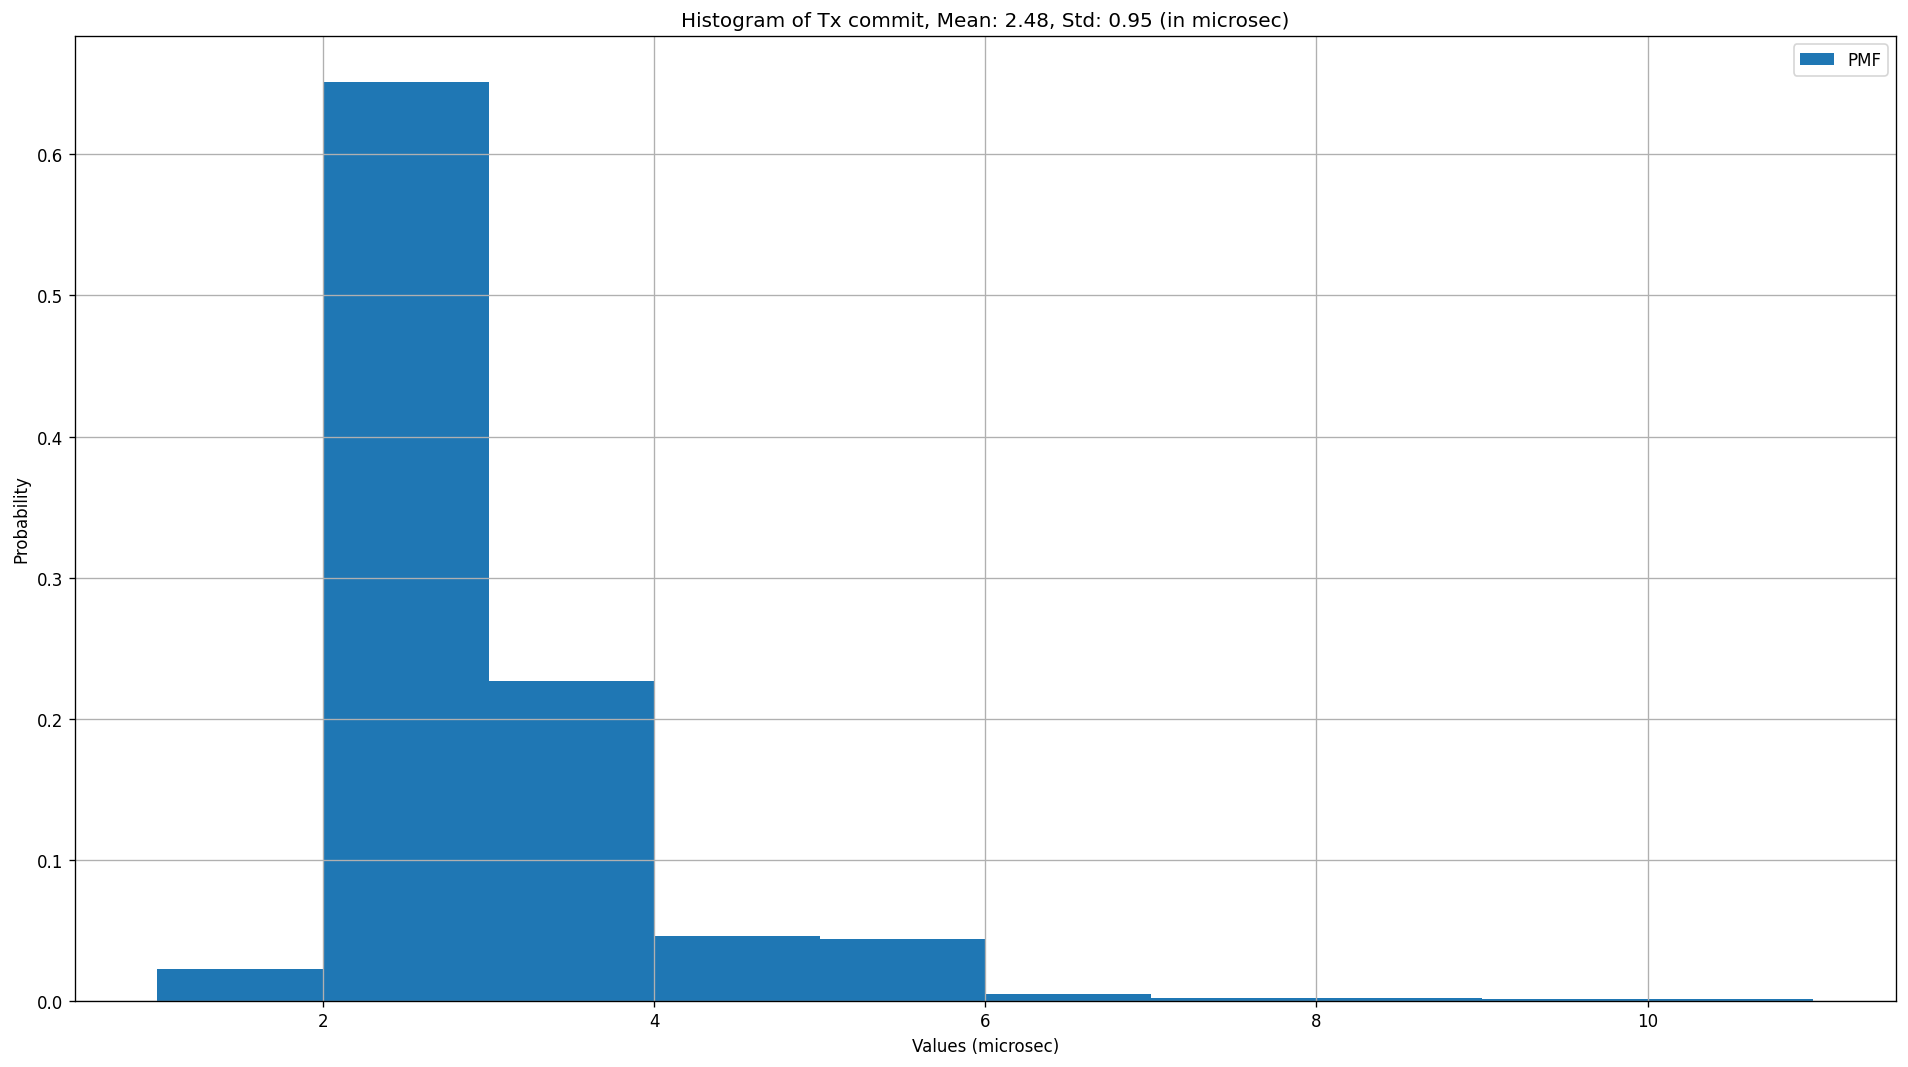

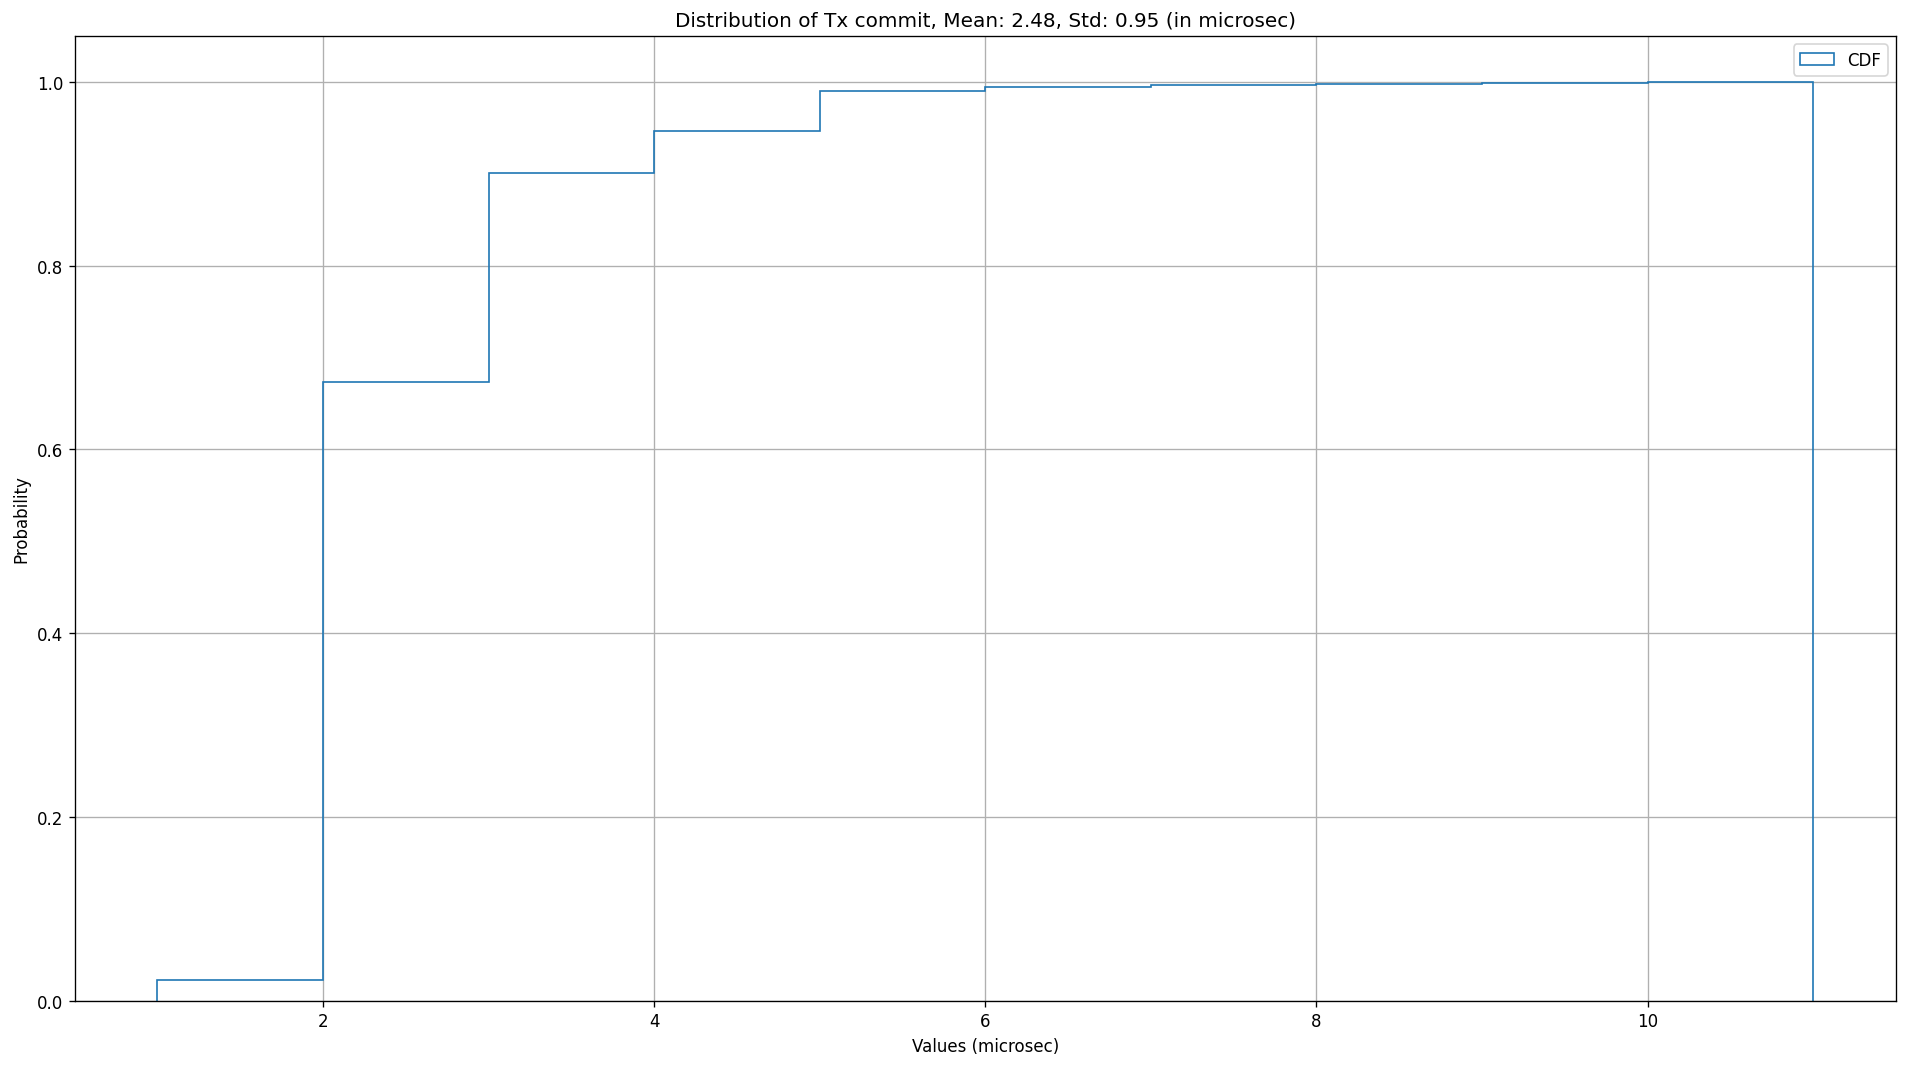

OU8 - TX Commit Features shape: (10000, 14)


,Num of reads,Num of writes,Num of active txs,Thread pool size,CPU utilization,Num of cache read,Num of cache insert,Num of cache update,Num of arithmetic operations,Num of write record,Num of bytes,Num of read write record,Num of log flush bytes,Num of Threads
0,2,0,1,50,3.0,4,0,0,0,0,0,2,0,61
1,2,0,1,50,4.0,4,0,0,0,0,0,2,0,61
2,2,0,1,50,4.0,4,0,0,0,0,0,2,0,61
3,2,0,1,50,3.0,4,0,0,0,0,0,2,0,61
4,2,0,1,50,0.0,4,0,0,0,0,0,2,0,61
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,2,0,1,50,0.0,4,0,0,0,0,0,2,0,61
9996,2,0,1,50,0.0,4,0,0,0,0,0,2,0,61
9997,2,0,1,50,0.0,4,0,0,0,0,0,2,0,61
9998,2,0,1,50,0.0,4,0,0,0,0,0,2,0,61


OU8 - TX Commit Targets shape: (10000,)


0        9410
1       10594
2        9728
3       10548
4       10546
        ...  
9995     2009
9996     1771
9997     2268
9998     2432
9999     2353
Name: Tx commit, Length: 10000, dtype: int64

In [7]:
# Features
featureNames = [
                'Num of reads', 'Num of writes',
                'Num of active txs', 'Thread pool size', 'CPU utilization',
                'Num of cache read', 'Num of cache insert', 'Num of cache update', 'Num of arithmetic operations',
                'Num of write record', 'Num of bytes',
                'Num of read write record', 'Num of log flush bytes',
                'Num of Threads'
                ]
# Prediction Targets
targetName = 'Tx commit'

# Create path for OU
figPathOU = makePath(figPath, targetName)
modelPathOU = makePath(modelPath, targetName)

# Prepare Data
commitFeatures, commitTargets = prepareData(features, records, featureNames=featureNames, targetName=targetName, figPath=figPathOU,
                                            warmupDrop=warmupDrop, outlinerDrop=outlinerDropR, sample=sampleN, histUnit=histUnit, isSaveFig=isSaveFig, isSC=isSC)
print(f'OU8 - TX Commit Features shape: {commitFeatures.shape}')
display(commitFeatures)
print(f'OU8 - TX Commit Targets shape: {commitTargets.shape}')
display(commitTargets)

X_train, X_test, y_train, y_test = train_test_split(commitFeatures, commitTargets, test_size=testSize, random_state=randomState)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


No handles with labels found to put in legend.


Best training/testing score: 0.1935/0.201
Best Params: {'alpha': 1.0, 'gamma': 0.5, 'kernel': 'rbf'}


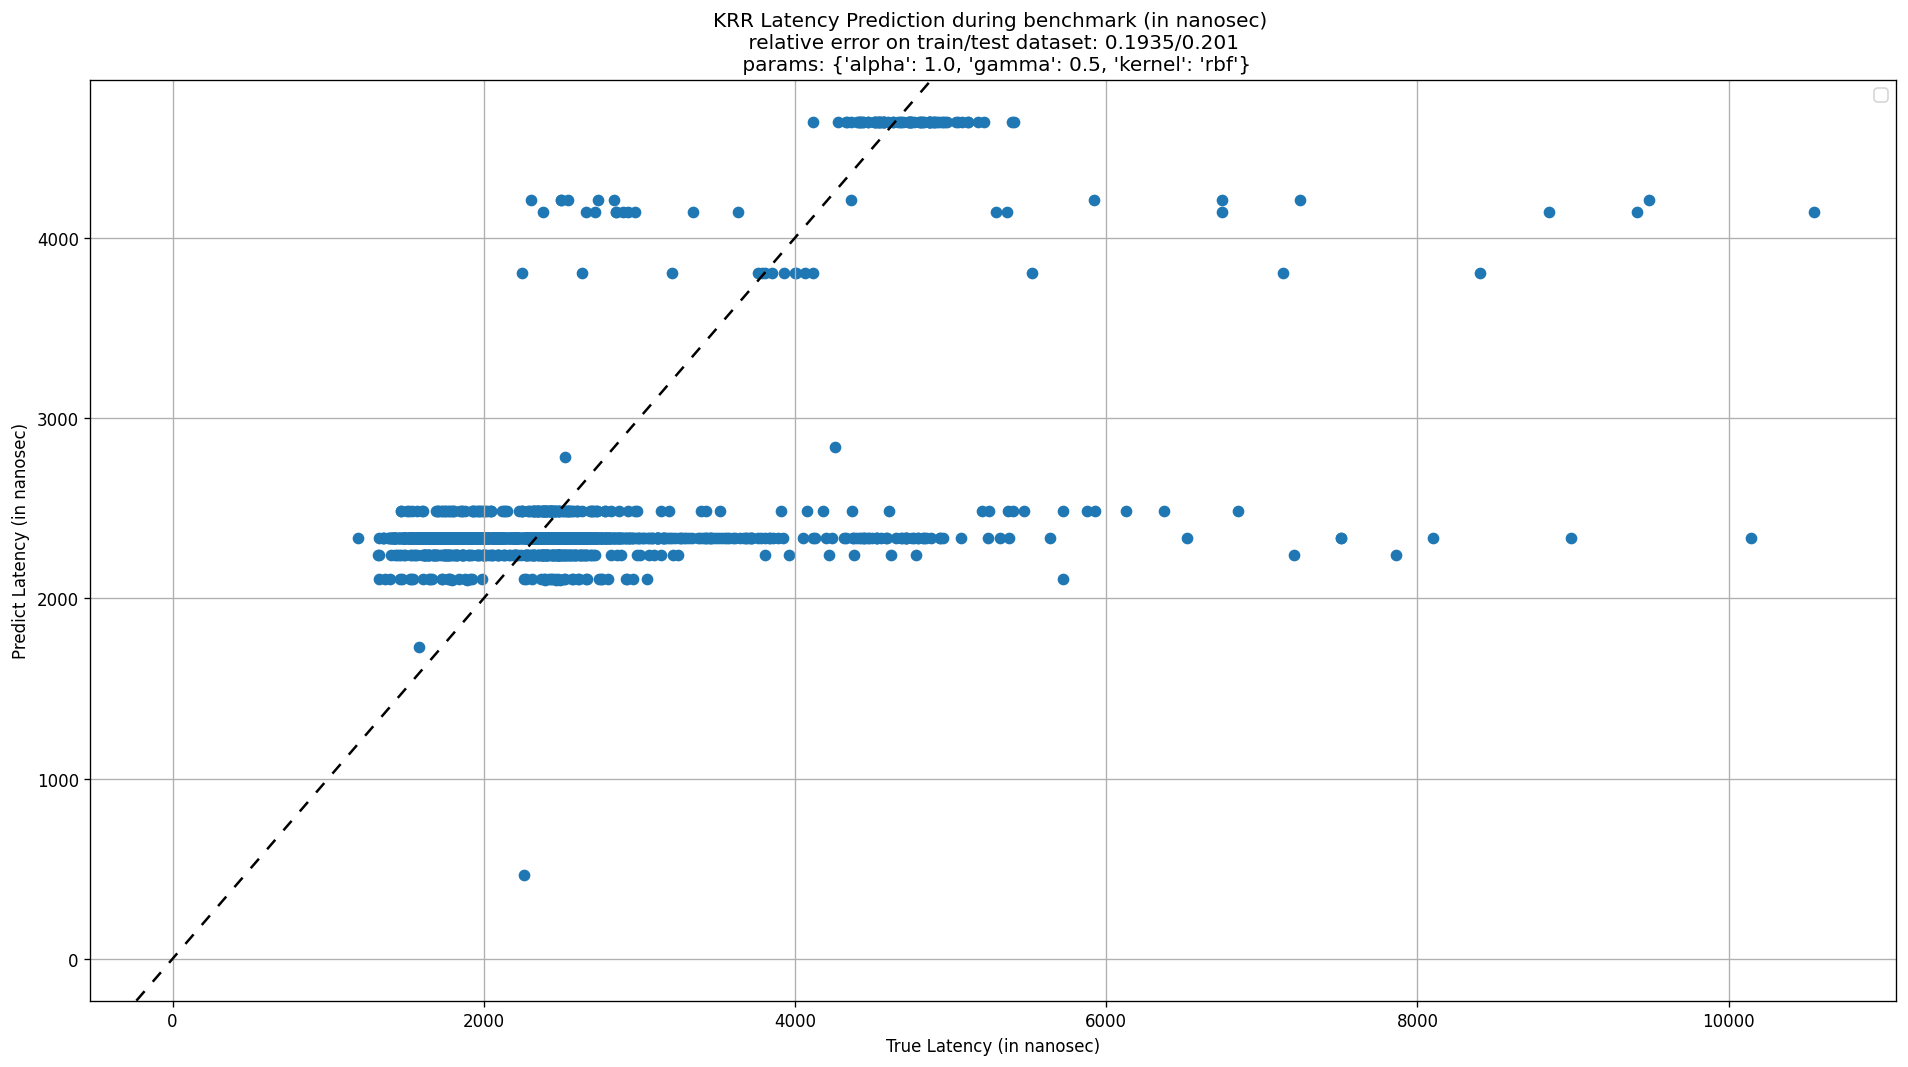

Fitting 5 folds for each of 20 candidates, totalling 100 fits


/home/weidagogo/anaconda3/envs/tempenv/lib/python3.7/site-packages/sklearn/model_selection/_search.py:925: UserWarning: One or more of the test scores are non-finite: [        nan         nan         nan         nan -0.21235371 -0.21154994
 -0.21122008 -0.21111564 -0.21139992 -0.2099818  -0.20957525 -0.20933308
 -0.20988837 -0.207219   -0.20644892 -0.2061233  -0.20765896 -0.20301164
 -0.20134256 -0.20071391]
  category=UserWarning
No handles with labels found to put in legend.


Best training/testing score: 0.2007/0.2058
Best Params: {'C': 4.0, 'gamma': 2.0, 'kernel': 'rbf'}


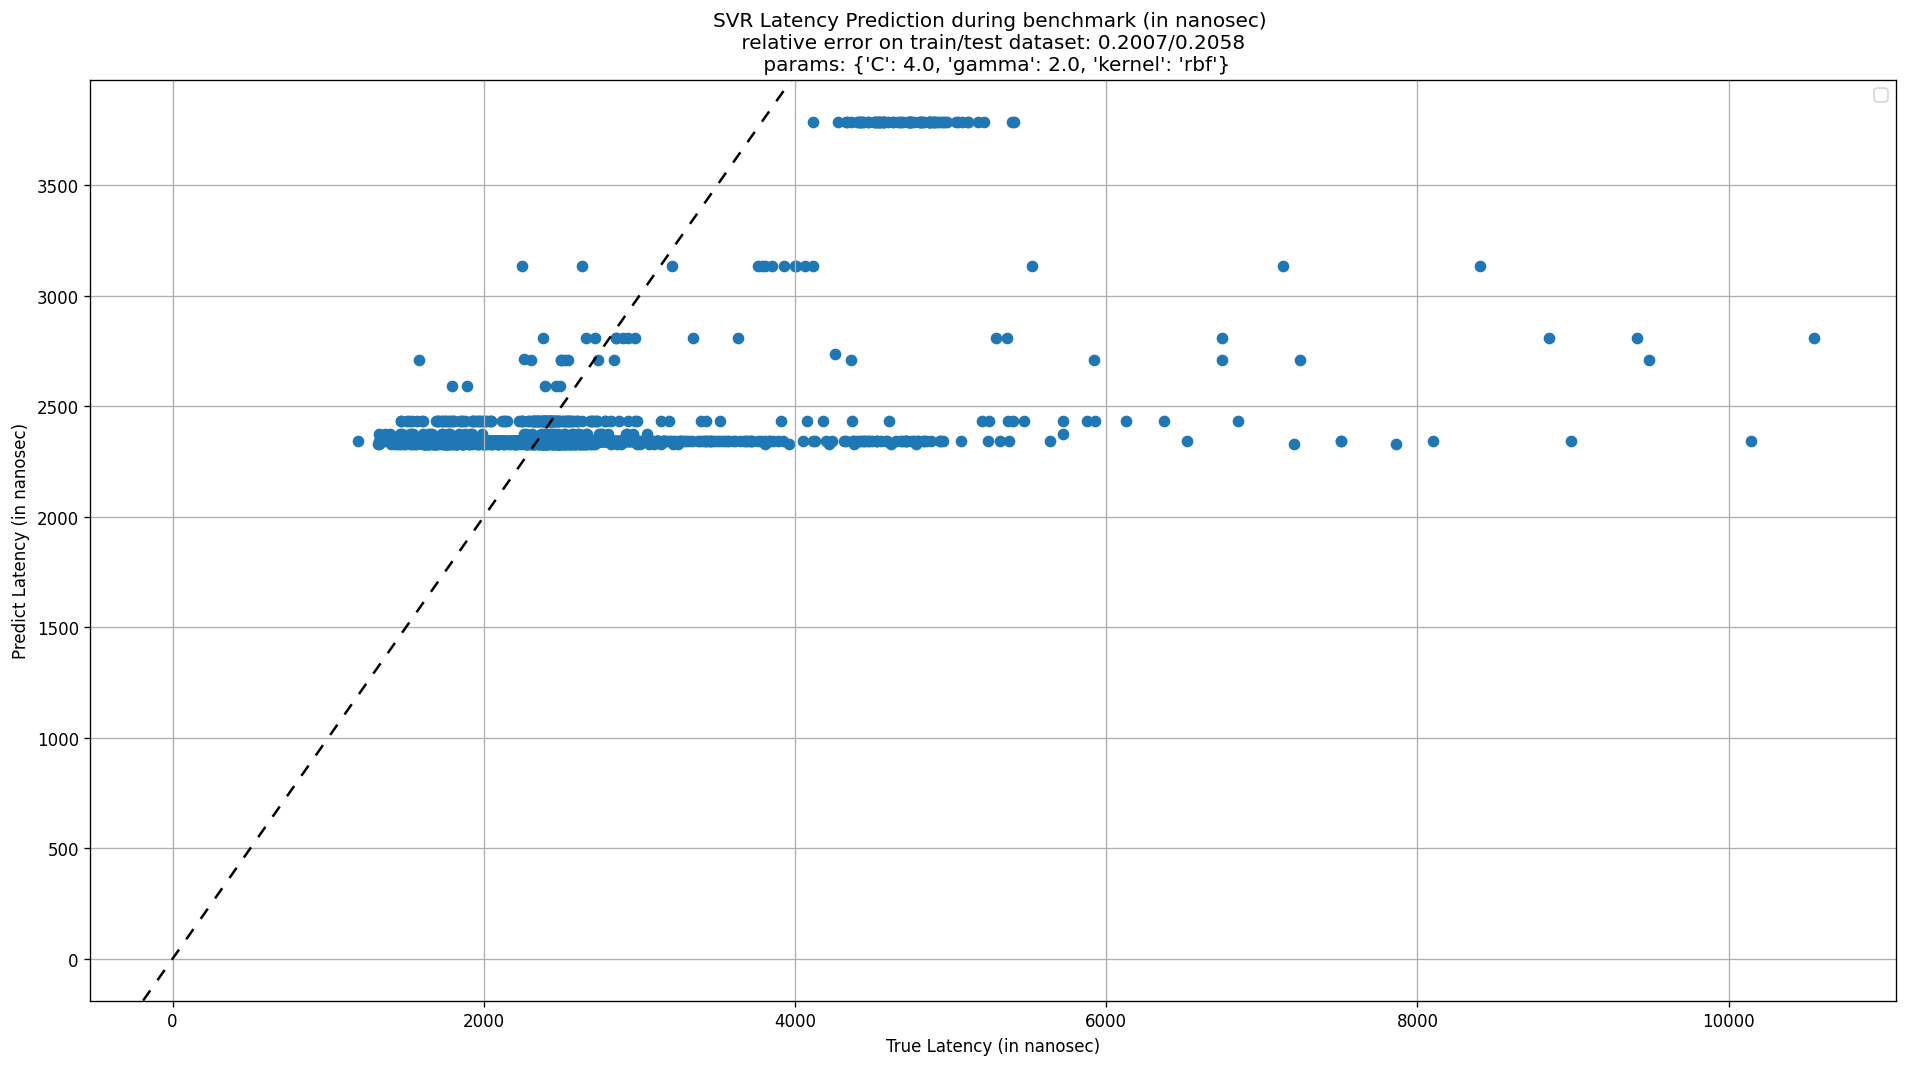

Fitting 5 folds for each of 20 candidates, totalling 100 fits


No handles with labels found to put in legend.


Best training/testing score: 0.2078/0.2148
Best Params: {'alpha': 1, 'epsilon': 1.35}


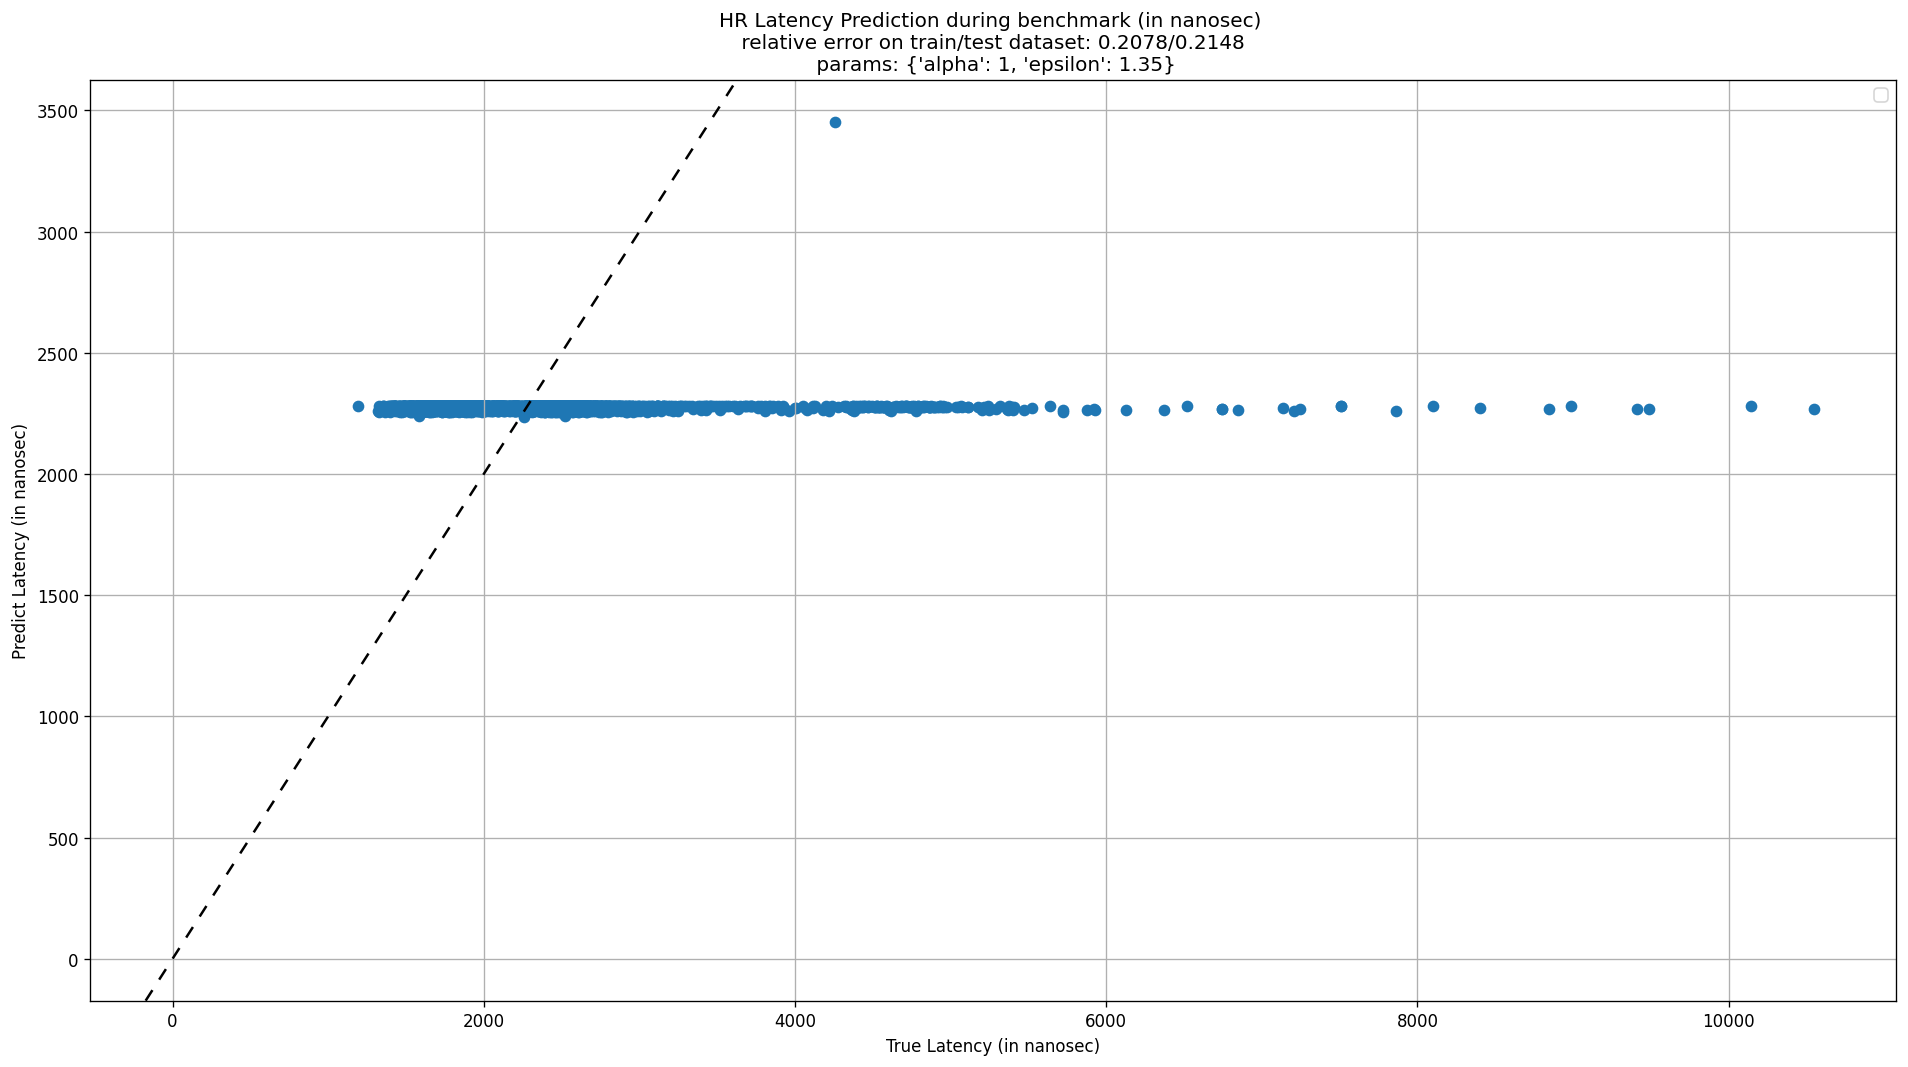

Fitting 5 folds for each of 24 candidates, totalling 120 fits


No handles with labels found to put in legend.


Best training/testing score: 0.1902/0.1972
Best Params: {'criterion': 'mae', 'max_depth': 7, 'n_estimators': 500, 'n_jobs': None, 'random_state': 0}


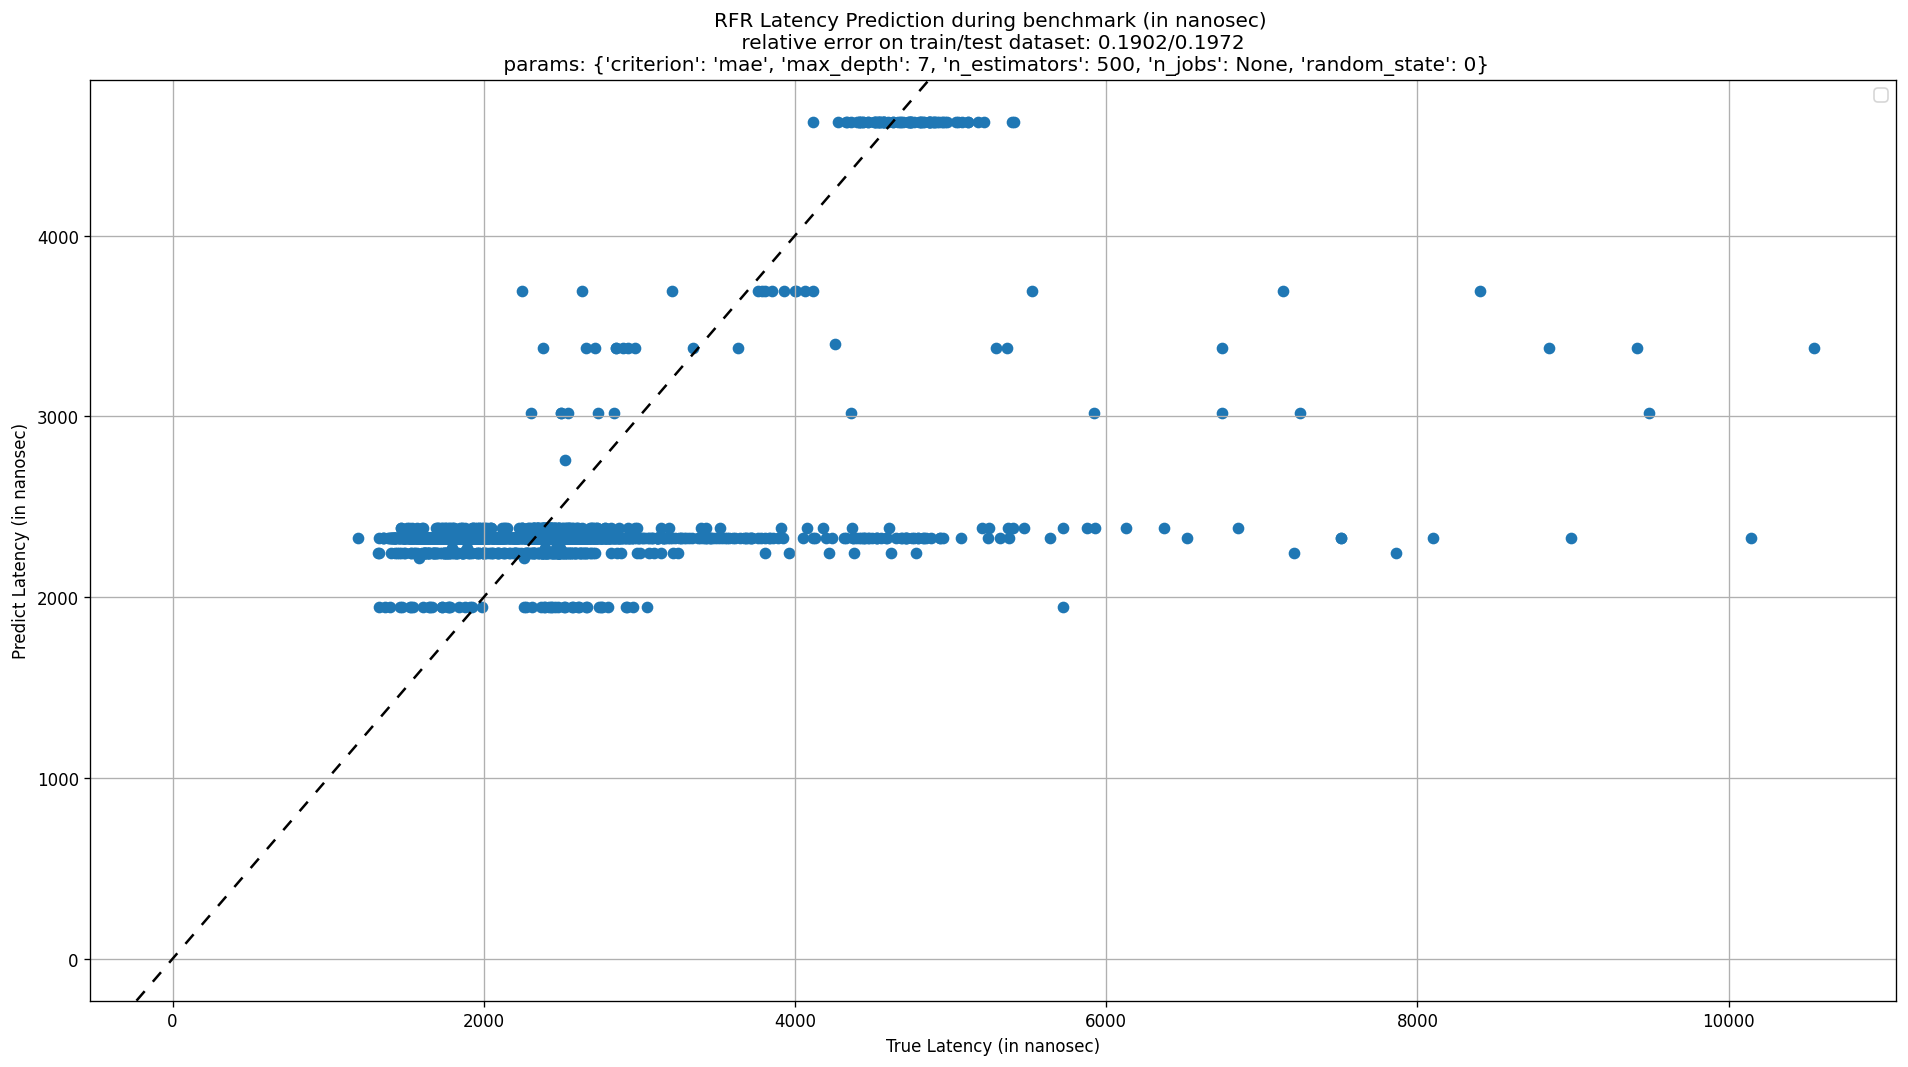

[(GridSearchCV(estimator=KernelRidge(), n_jobs=-1,
               param_grid={'alpha': [1.0], 'gamma': [0.1, 0.5, 1.0, 2.0],
                           'kernel': ['rbf']},
               scoring='neg_mean_absolute_percentage_error', verbose=2),
  0.1935,
  0.201),
 (GridSearchCV(estimator=SVR(), n_jobs=-1,
               param_grid={'C': [0, 0.5, 1.0, 2.0, 4.0],
                           'gamma': [0.1, 0.5, 1.0, 2.0], 'kernel': ['rbf']},
               scoring='neg_mean_absolute_percentage_error', verbose=2),
  0.2007,
  0.2058),
 (GridSearchCV(estimator=HuberRegressor(), n_jobs=-1,
               param_grid={'alpha': [0, 0.0001, 0.01, 0.1, 1],
                           'epsilon': [1.1, 1.35, 2, 5]},
               scoring='neg_mean_absolute_percentage_error', verbose=2),
  0.2078,
  0.2148),
 (GridSearchCV(estimator=RandomForestRegressor(), n_jobs=-1,
               param_grid={'criterion': ['mse', 'mae'],
                           'max_depth': [3, 5, 7, 10],
                      

In [8]:
Parallel(n_jobs=1)(delayed(modelSearch)(m['model'], X_train, X_test, y_train, y_test, name=m['name'], params=m['param'], 
                                        figPath=figPathOU, modelPath=modelPathOU, isSaveFig=isSaveFig, isSaveModel=isSaveModel, n_jobs=-1) for m in modelList)

In [9]:
# rt.fit(featureNames=featureNames, targetName=targetName)

# Write Back To Storage

Warm Up Drop Timestamp: 205712299
In microsec, Number of bins: 7, nBins: [0. 1. 2. 3. 4. 5. 6.]
Mean Latency: 0.19, Std Latency: 0.48 (microsec)


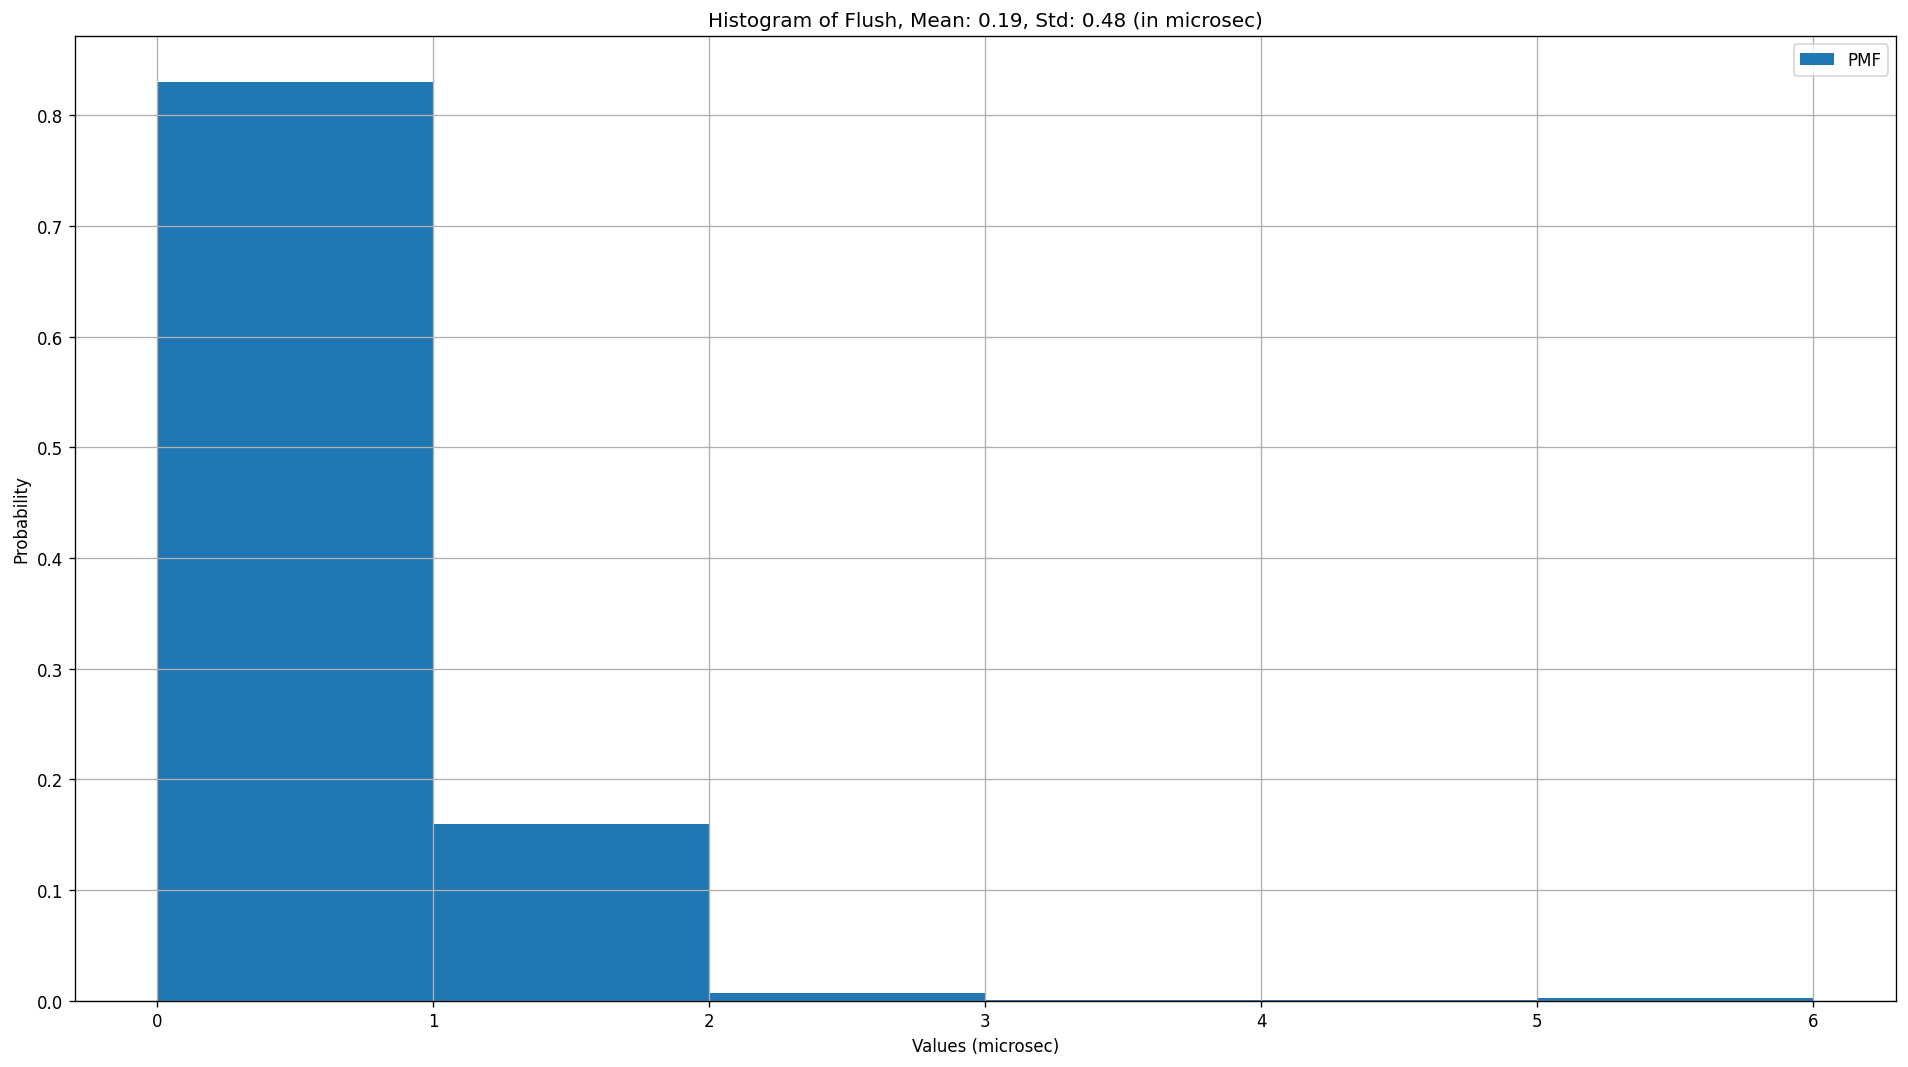

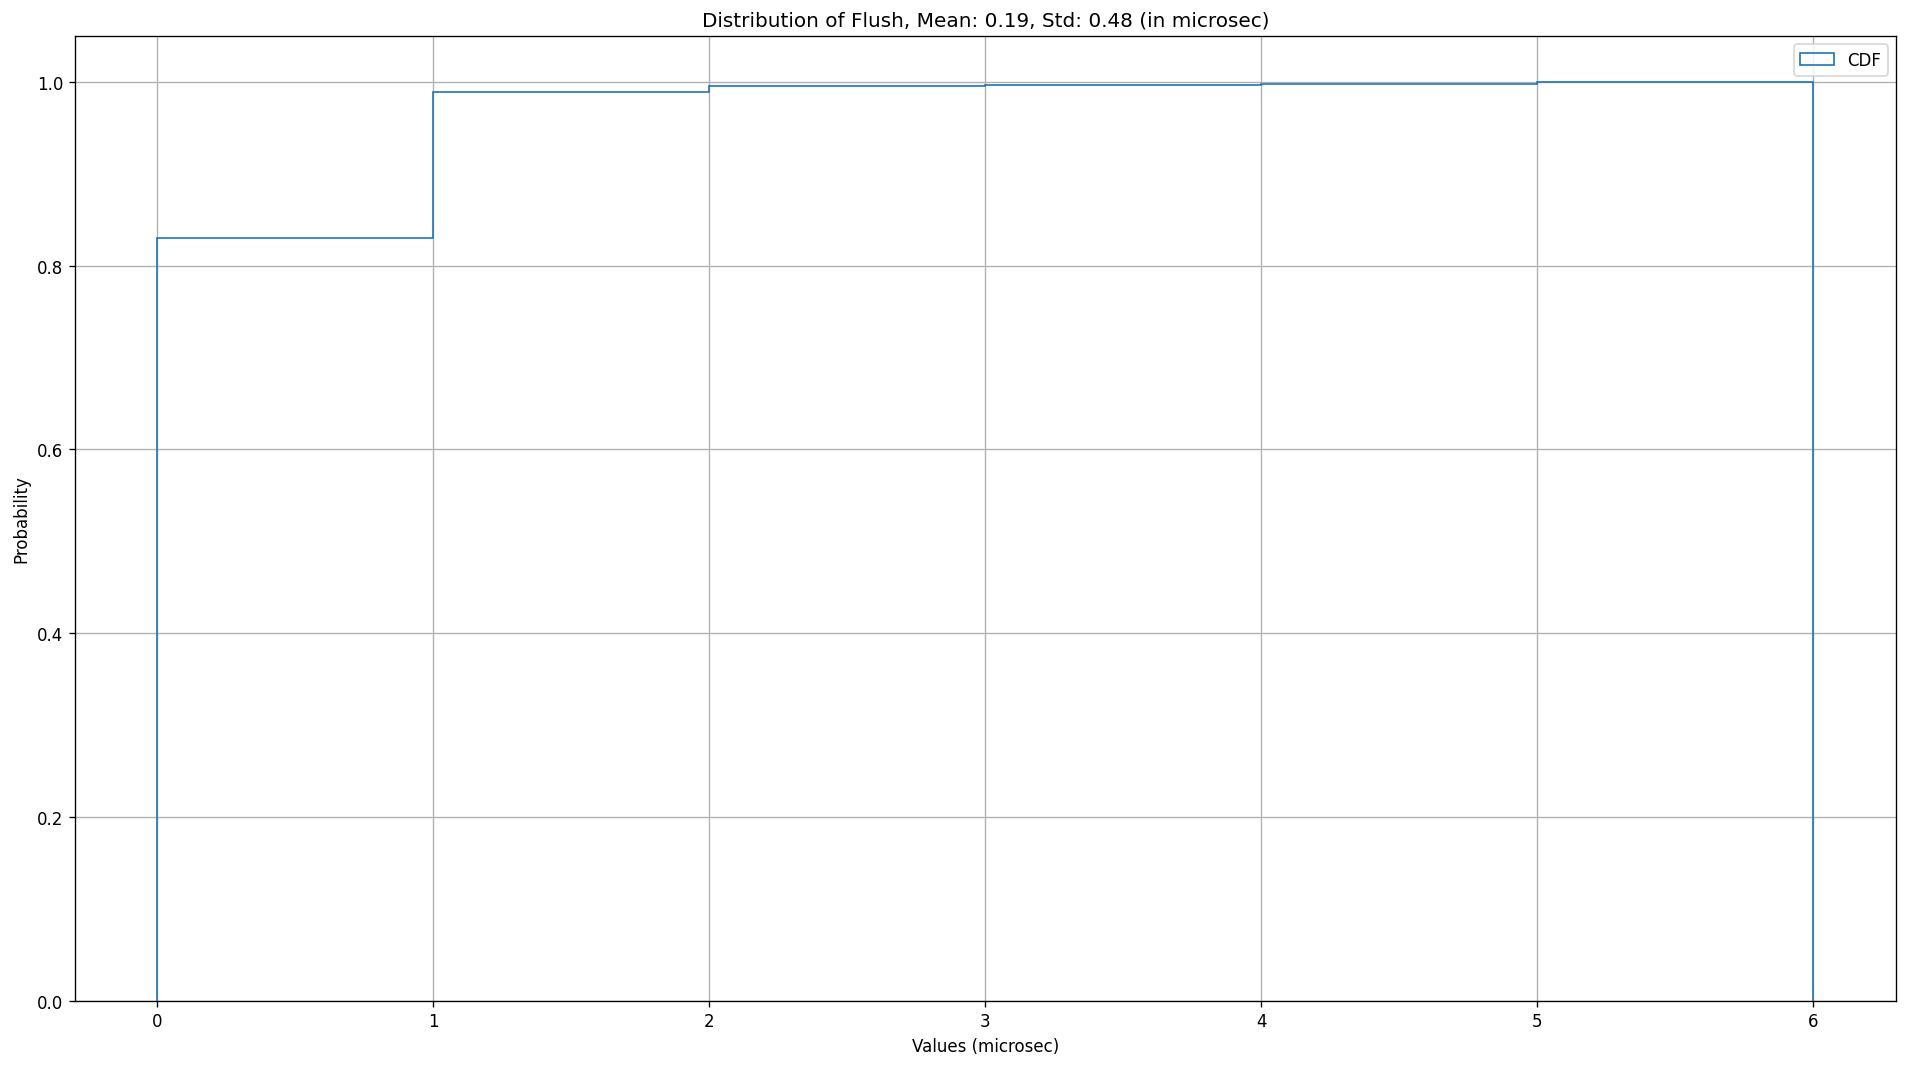

OU7 - Write Local Storage Features shape: (10000, 14)


,Num of reads,Num of writes,Num of active txs,Thread pool size,CPU utilization,Num of cache read,Num of cache insert,Num of cache update,Num of arithmetic operations,Num of write record,Num of bytes,Num of read write record,Num of log flush bytes,Num of Threads
0,2,0,1,50,4.0,4,0,0,0,0,0,2,0,41
1,2,0,1,50,3.0,4,0,0,0,0,0,2,0,44
2,2,0,1,50,2.0,4,0,0,0,0,0,2,0,57
3,2,0,1,50,4.0,4,0,0,0,0,0,2,0,61
4,2,0,1,50,2.0,4,0,0,0,0,0,2,0,61
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,2,0,1,50,0.0,4,0,0,0,0,0,2,0,61
9996,2,0,1,50,0.0,4,0,0,0,0,0,2,0,61
9997,2,0,1,50,0.0,4,0,0,0,0,0,2,0,61
9998,2,0,1,50,0.0,4,0,0,0,0,0,2,0,61


OU7 - Write Local Storage Targets shape: (10000,)


0       4694
1       5248
2       5173
3       4839
4       4427
        ... 
9995     447
9996     383
9997     373
9998     503
9999     435
Name: Flush, Length: 10000, dtype: int64

In [10]:
featureNames = [
                'Num of reads', 'Num of writes',
                'Num of active txs', 'Thread pool size', 'CPU utilization',
                'Num of cache read', 'Num of cache insert', 'Num of cache update', 'Num of arithmetic operations',
                'Num of write record', 'Num of bytes',
                'Num of read write record', 'Num of log flush bytes',
                'Num of Threads'
                ]
targetName = 'Flush'

# Create path for OU
figPathOU = makePath(figPath, targetName)
modelPathOU = makePath(modelPath, targetName)

wLocalStorageFeatures, wLocalStorageTargets = prepareData(features, records, featureNames=featureNames, targetName=targetName, figPath=figPathOU, 
                                                          warmupDrop=warmupDrop, outlinerDrop=outlinerDropR, sample=sampleN, histUnit=histUnit, isSaveFig=isSaveFig, isSC=isSC)
print(f'OU7 - Write Local Storage Features shape: {wLocalStorageFeatures.shape}')
display(wLocalStorageFeatures)
print(f'OU7 - Write Local Storage Targets shape: {wLocalStorageTargets.shape}')
display(wLocalStorageTargets)

X_train, X_test, y_train, y_test = train_test_split(wLocalStorageFeatures, wLocalStorageTargets, test_size=testSize, random_state=randomState)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


No handles with labels found to put in legend.


Best training/testing score: 0.1868/0.1876
Best Params: {'alpha': 1.0, 'gamma': 2.0, 'kernel': 'rbf'}


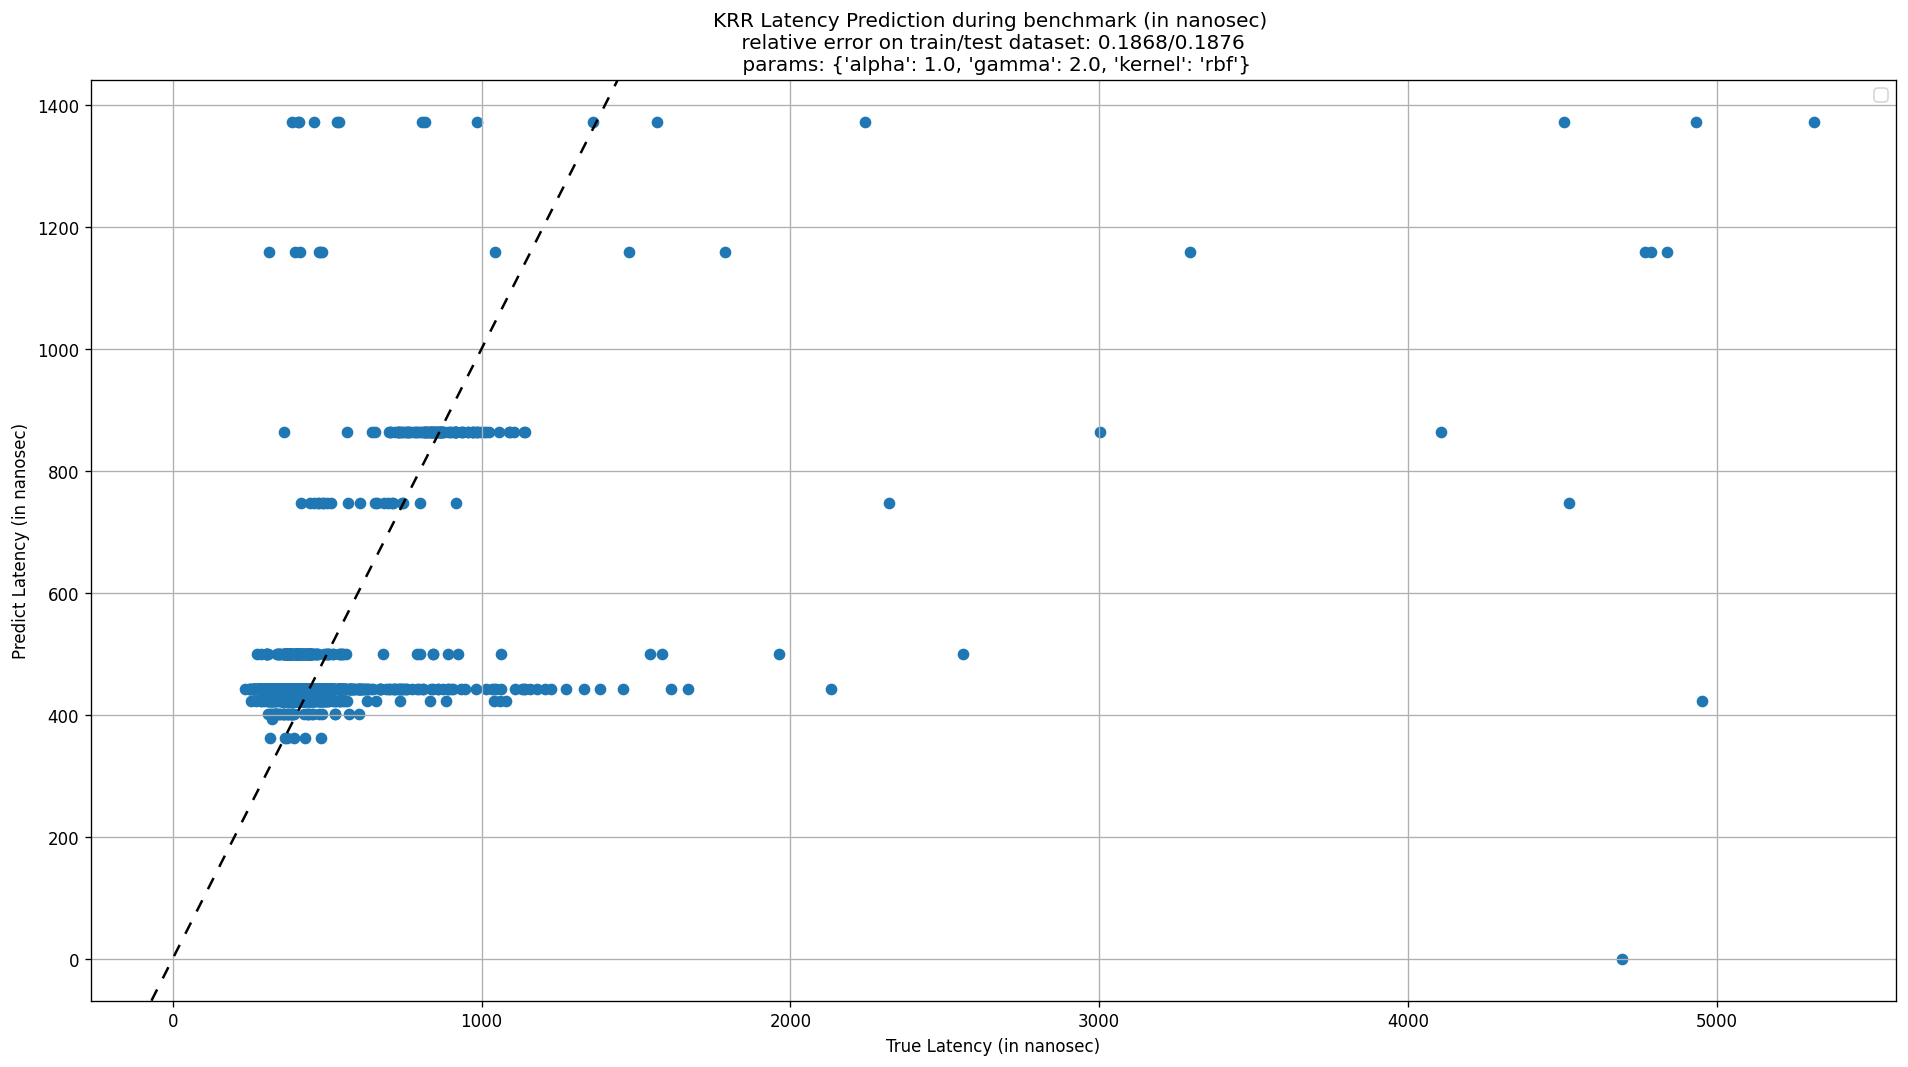

Fitting 5 folds for each of 20 candidates, totalling 100 fits


/home/weidagogo/anaconda3/envs/tempenv/lib/python3.7/site-packages/sklearn/model_selection/_search.py:925: UserWarning: One or more of the test scores are non-finite: [        nan         nan         nan         nan -0.16099871 -0.15785164
 -0.15638261 -0.15559338 -0.15979761 -0.15463659 -0.15164905 -0.15030028
 -0.15840813 -0.15033724 -0.14795057 -0.14739633 -0.15643771 -0.14806838
 -0.14658181 -0.14631835]
  category=UserWarning
No handles with labels found to put in legend.


Best training/testing score: 0.1463/0.145
Best Params: {'C': 4.0, 'gamma': 2.0, 'kernel': 'rbf'}


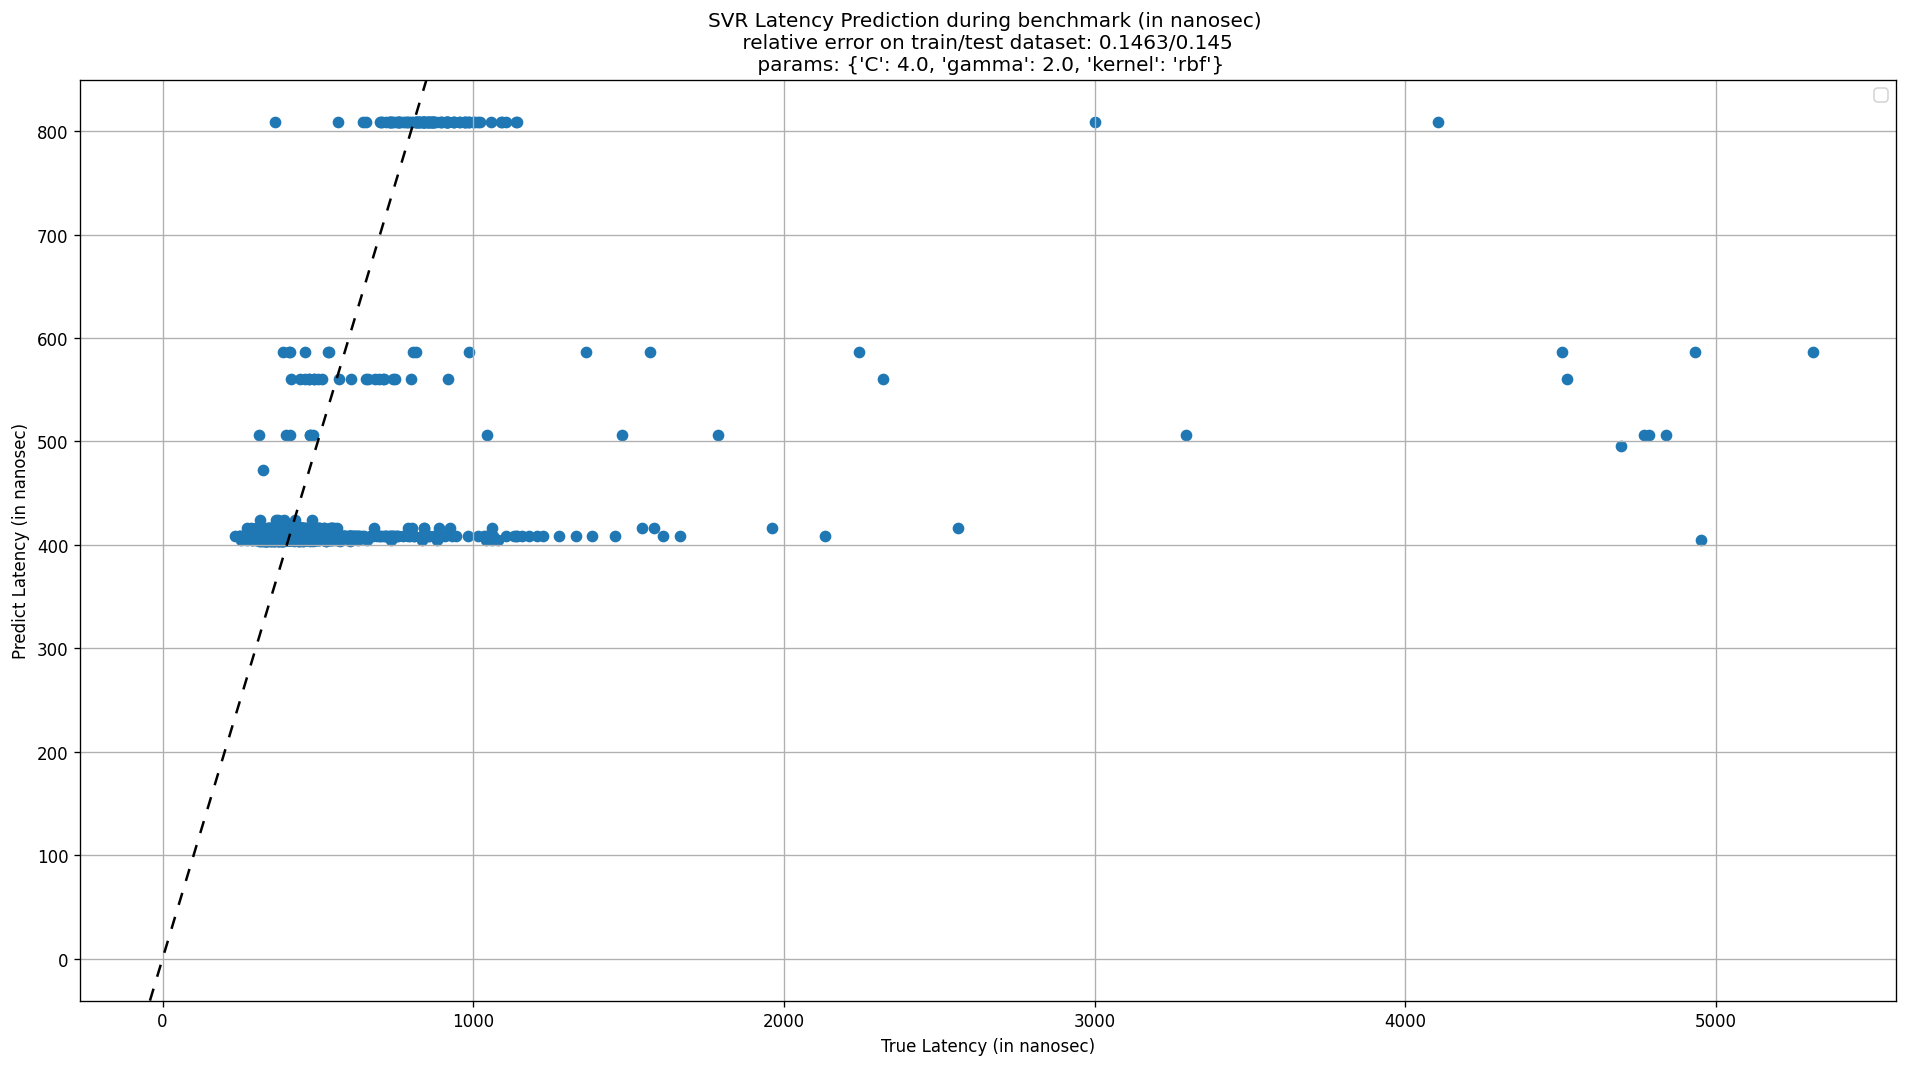

Fitting 5 folds for each of 20 candidates, totalling 100 fits


No handles with labels found to put in legend.


Best training/testing score: 0.164/0.1657
Best Params: {'alpha': 0, 'epsilon': 1.1}


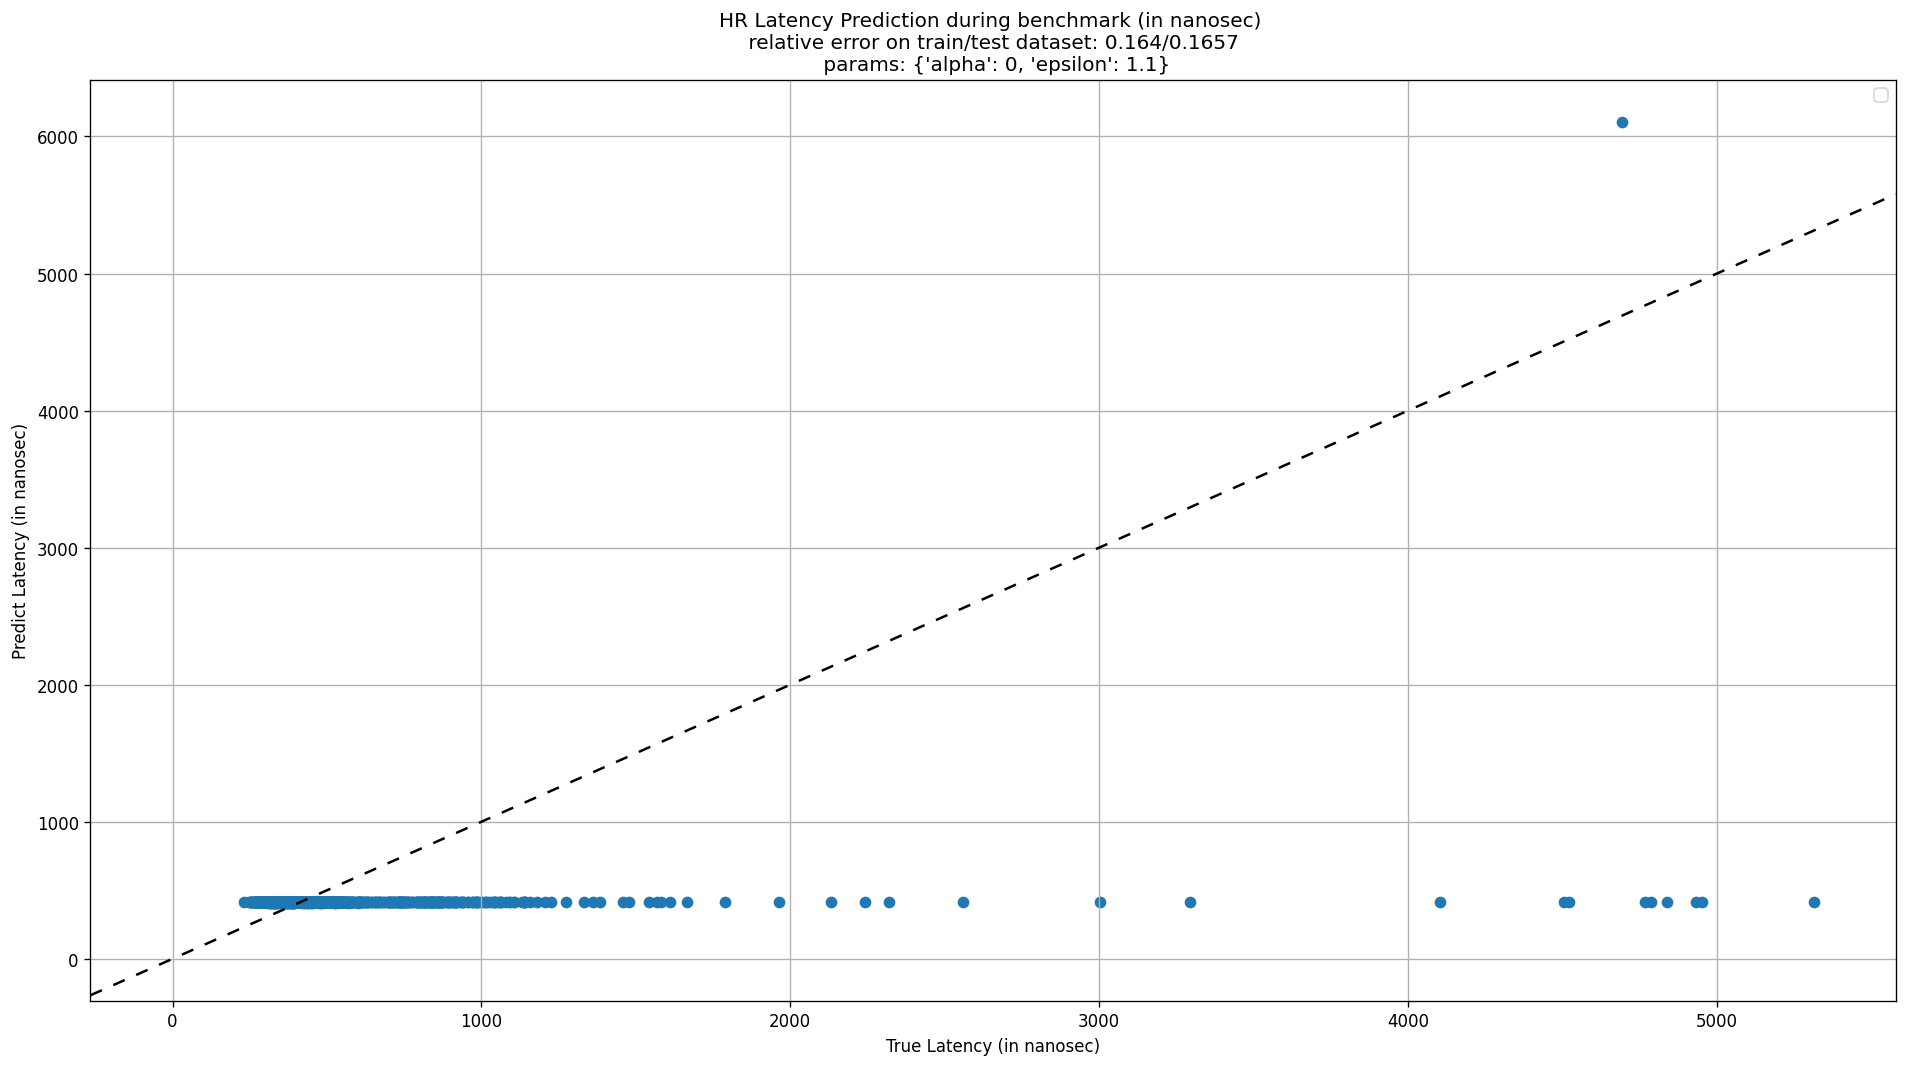

Fitting 5 folds for each of 24 candidates, totalling 120 fits


No handles with labels found to put in legend.


Best training/testing score: 0.1467/0.1448
Best Params: {'criterion': 'mae', 'max_depth': 5, 'n_estimators': 100, 'n_jobs': None, 'random_state': 0}


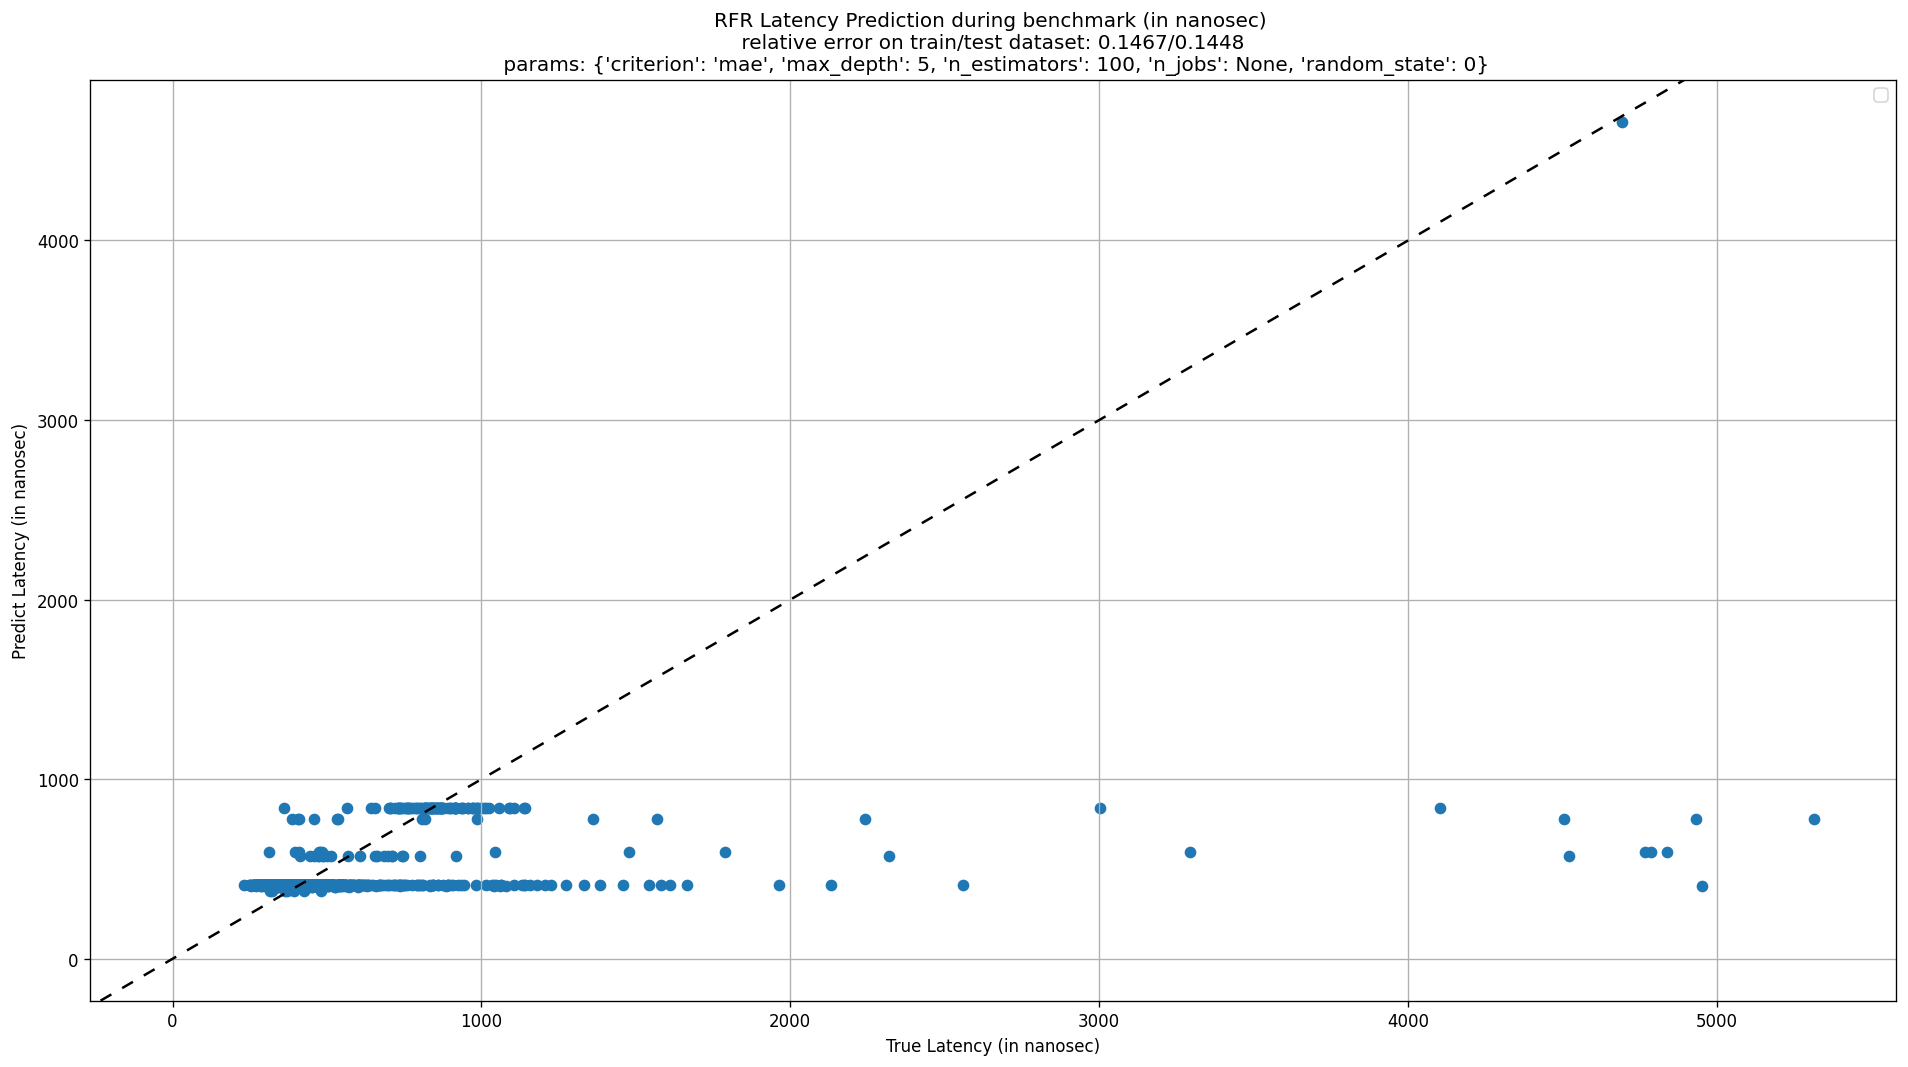

[(GridSearchCV(estimator=KernelRidge(), n_jobs=-1,
               param_grid={'alpha': [1.0], 'gamma': [0.1, 0.5, 1.0, 2.0],
                           'kernel': ['rbf']},
               scoring='neg_mean_absolute_percentage_error', verbose=2),
  0.1868,
  0.1876),
 (GridSearchCV(estimator=SVR(), n_jobs=-1,
               param_grid={'C': [0, 0.5, 1.0, 2.0, 4.0],
                           'gamma': [0.1, 0.5, 1.0, 2.0], 'kernel': ['rbf']},
               scoring='neg_mean_absolute_percentage_error', verbose=2),
  0.1463,
  0.145),
 (GridSearchCV(estimator=HuberRegressor(), n_jobs=-1,
               param_grid={'alpha': [0, 0.0001, 0.01, 0.1, 1],
                           'epsilon': [1.1, 1.35, 2, 5]},
               scoring='neg_mean_absolute_percentage_error', verbose=2),
  0.164,
  0.1657),
 (GridSearchCV(estimator=RandomForestRegressor(), n_jobs=-1,
               param_grid={'criterion': ['mse', 'mae'],
                           'max_depth': [3, 5, 7, 10],
                       

In [11]:
Parallel(n_jobs=1)(delayed(modelSearch)(m['model'], X_train, X_test, y_train, y_test, name=m['name'], params=m['param'], 
                                        figPath=figPathOU, modelPath=modelPathOU, isSaveFig=isSaveFig, isSaveModel=isSaveModel, n_jobs=-1) for m in modelList)

# Execute Txn Logic

Warm Up Drop Timestamp: 205712299
In microsec, Number of bins: 2, nBins: [0. 1.]
Mean Latency: 0.56, Std Latency: 0.5 (microsec)


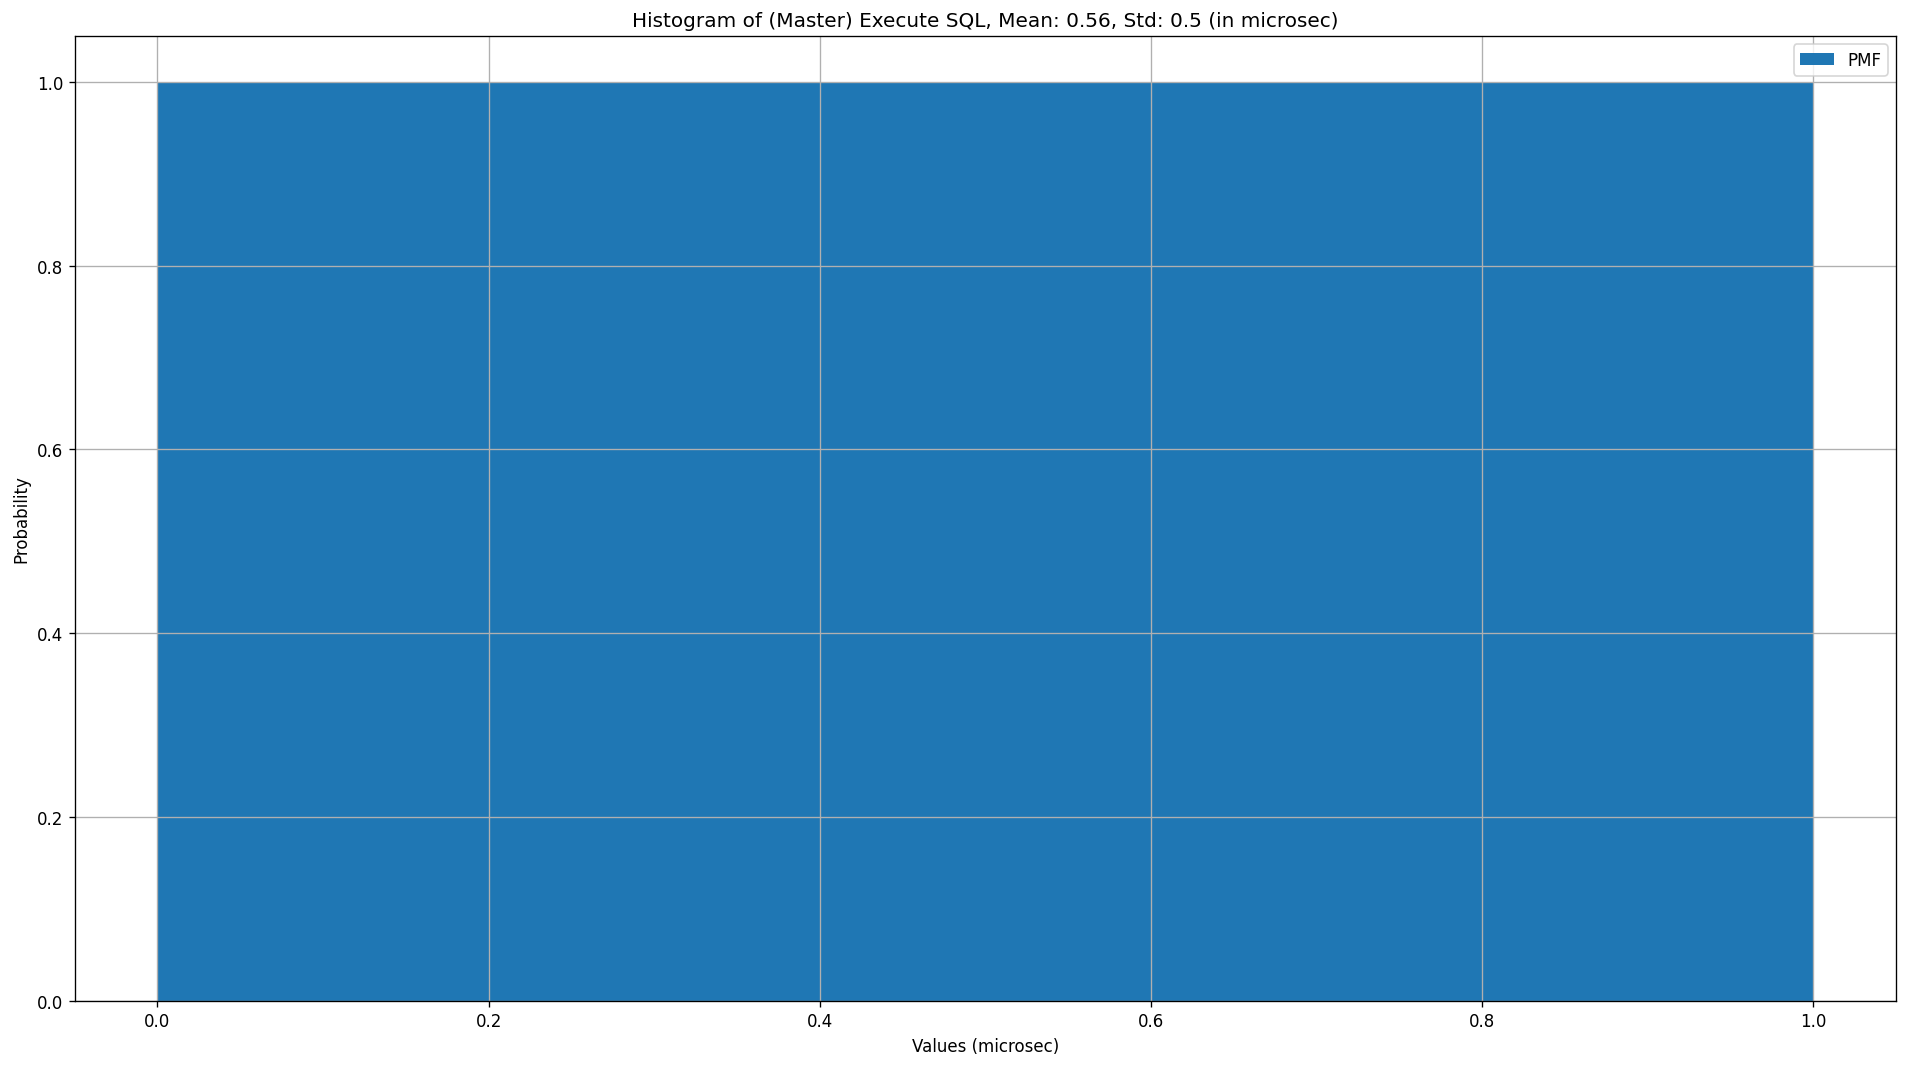

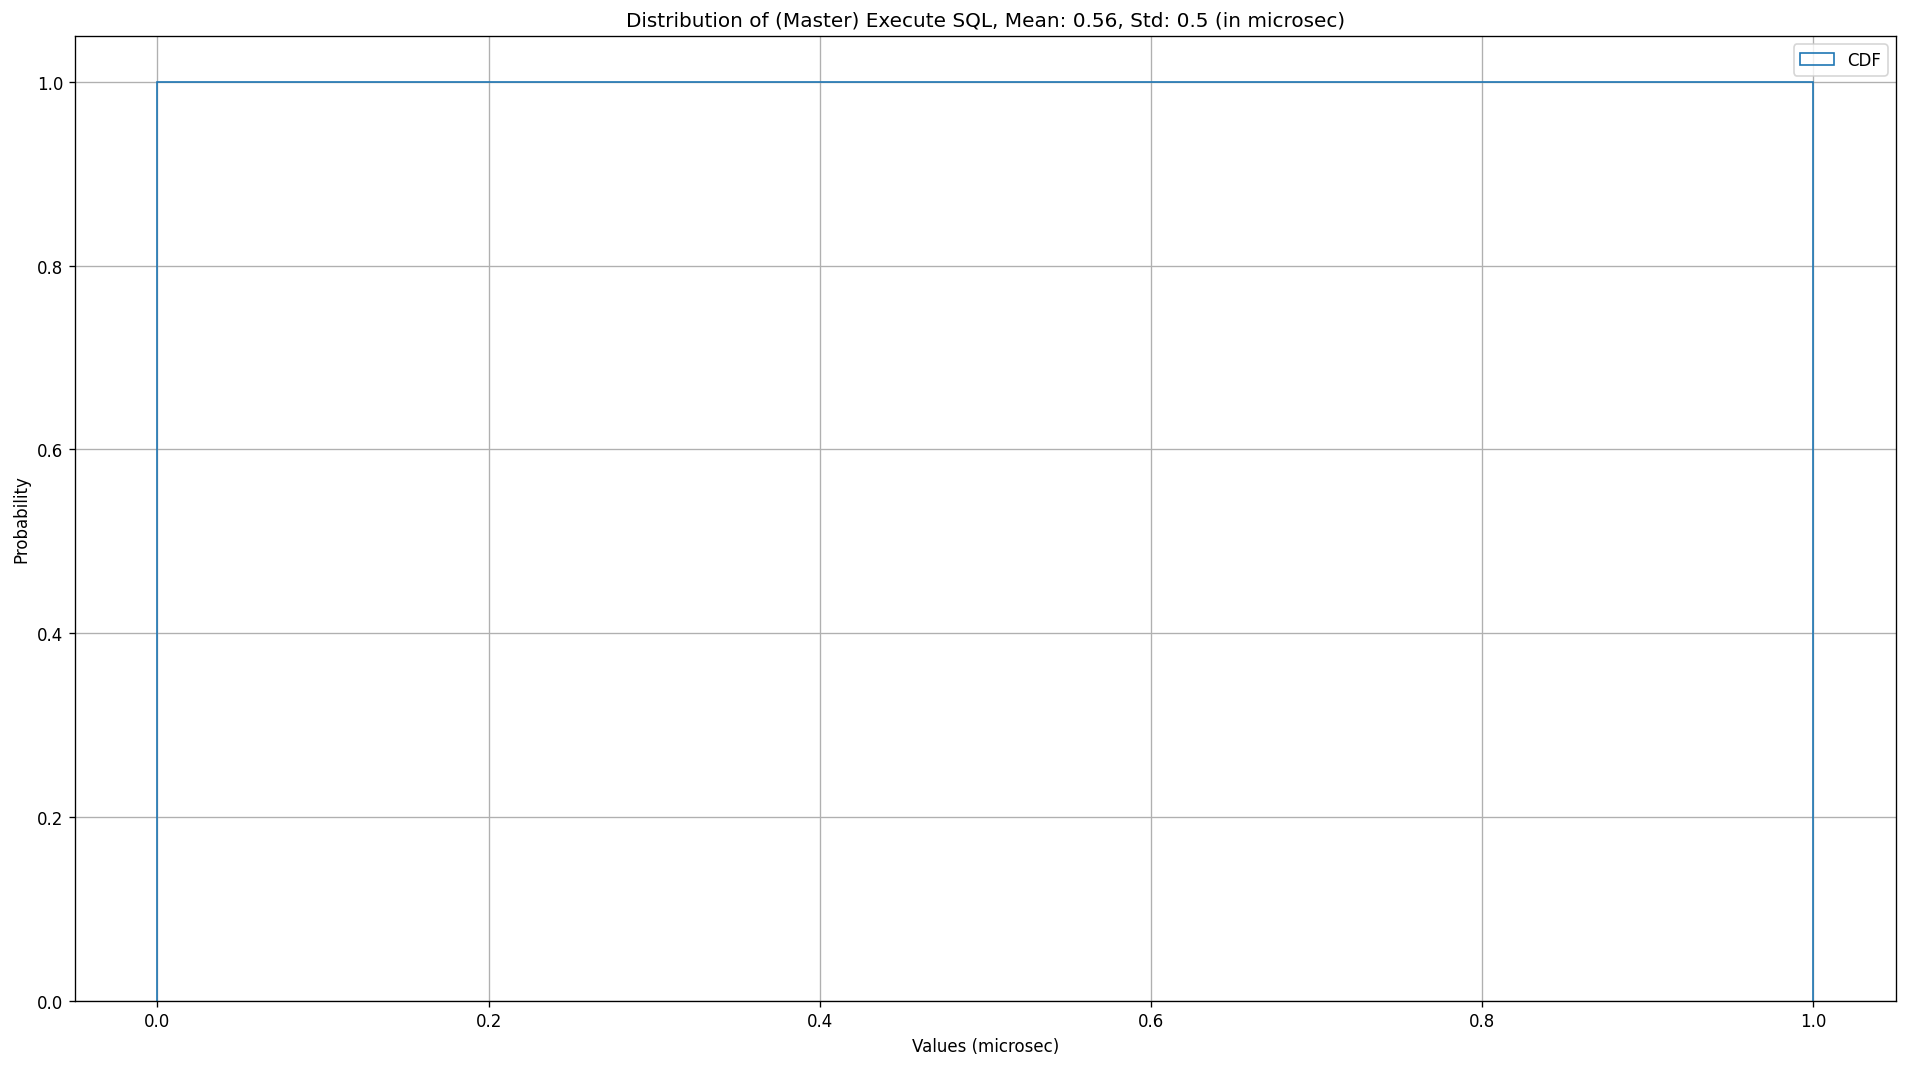

OU6 - Eexecute SQL Features shape: (10000, 14)


,Num of reads,Num of writes,Num of active txs,Thread pool size,CPU utilization,Num of cache read,Num of cache insert,Num of cache update,Num of arithmetic operations,Num of write record,Num of bytes,Num of read write record,Num of log flush bytes,Num of Threads
0,2,0,1,50,4.0,4,0,0,0,0,0,2,0,61
1,2,0,1,50,5.0,4,0,0,0,0,0,2,0,61
2,2,0,1,50,0.0,4,0,0,0,0,0,2,0,61
3,2,0,1,50,0.0,4,0,0,0,0,0,2,0,61
4,2,0,1,50,0.0,4,0,0,0,0,0,2,0,61
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,2,0,1,50,0.0,4,0,0,0,0,0,2,0,61
9996,2,0,1,50,0.0,4,0,0,0,0,0,2,0,61
9997,2,0,1,50,0.0,4,0,0,0,0,0,2,0,61
9998,2,0,1,50,0.0,4,0,0,0,0,0,2,0,61


OU6 - Eexecute SQL Targets shape: (10000,)


0       1331
1       1281
2       1347
3       1237
4       1371
        ... 
9995     378
9996     351
9997     445
9998     480
9999     497
Name: (Master) Execute SQL, Length: 10000, dtype: int64

In [12]:
featureNames = [
                'Num of reads', 'Num of writes',
                'Num of active txs', 'Thread pool size', 'CPU utilization',
                'Num of cache read', 'Num of cache insert', 'Num of cache update', 'Num of arithmetic operations',
                'Num of write record', 'Num of bytes',
                'Num of read write record', 'Num of log flush bytes',
                'Num of Threads'
                ]
targetName = '(Master) Execute SQL'

# Create path for OU
figPathOU = makePath(figPath, targetName)
modelPathOU = makePath(modelPath, targetName)

exeSqlFeatures, exeSqlTargets = prepareData(features, records, featureNames=featureNames, targetName=targetName, figPath=figPathOU,
                                            warmupDrop=warmupDrop, outlinerDrop=outlinerDropR, sample=sampleN, histUnit=histUnit, isSaveFig=isSaveFig, isSC=isSC)
print(f'OU6 - Eexecute SQL Features shape: {exeSqlFeatures.shape}')
display(exeSqlFeatures)
print(f'OU6 - Eexecute SQL Targets shape: {exeSqlTargets.shape}')
display(exeSqlTargets)

X_train, X_test, y_train, y_test = train_test_split(exeSqlFeatures, exeSqlTargets, test_size=testSize, random_state=randomState)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


No handles with labels found to put in legend.


Best training/testing score: 0.195/0.2027
Best Params: {'alpha': 1.0, 'gamma': 0.5, 'kernel': 'rbf'}


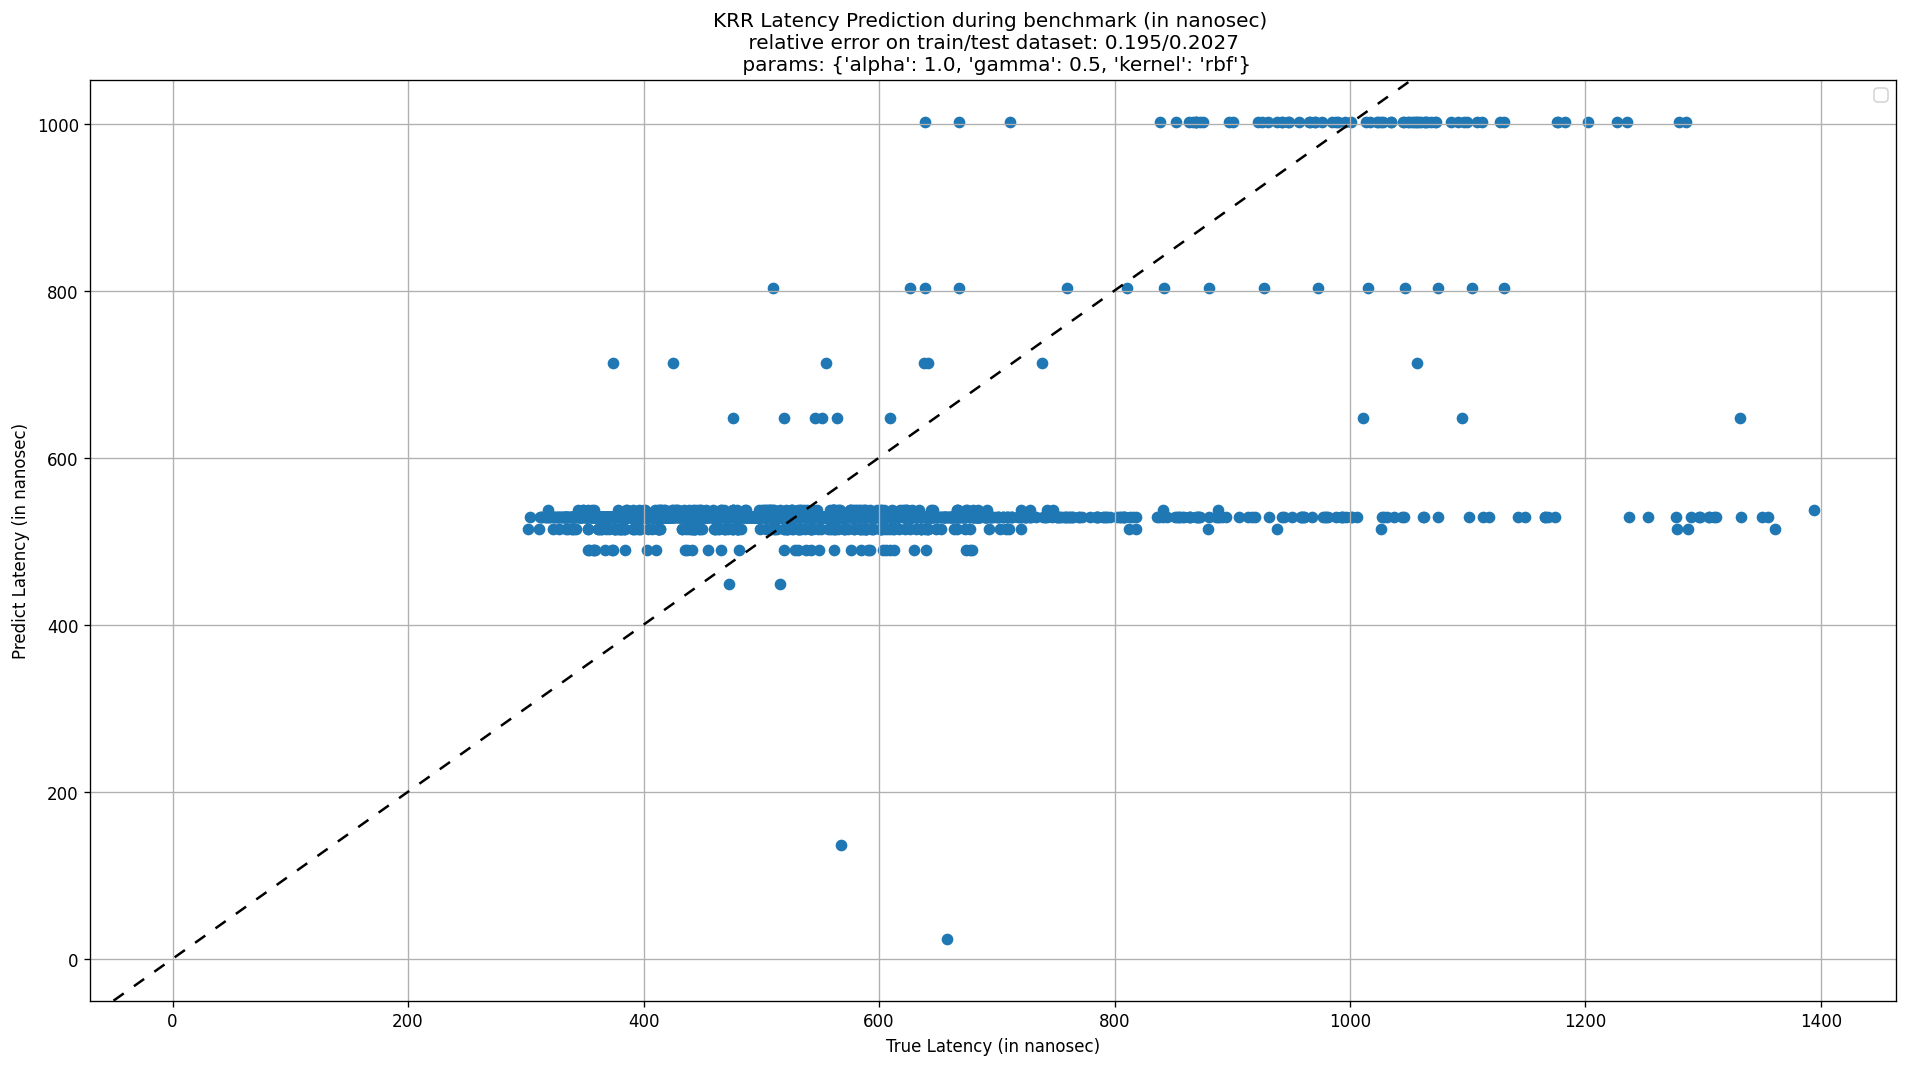

Fitting 5 folds for each of 20 candidates, totalling 100 fits


/home/weidagogo/anaconda3/envs/tempenv/lib/python3.7/site-packages/sklearn/model_selection/_search.py:925: UserWarning: One or more of the test scores are non-finite: [        nan         nan         nan         nan -0.2046731  -0.20196581
 -0.20091201 -0.20038043 -0.20308182 -0.19821025 -0.19603893 -0.19530009
 -0.20101419 -0.1938415  -0.19130899 -0.19099409 -0.1988126  -0.1904874
 -0.18927949 -0.1893209 ]
  category=UserWarning
No handles with labels found to put in legend.


Best training/testing score: 0.1893/0.1956
Best Params: {'C': 4.0, 'gamma': 1.0, 'kernel': 'rbf'}


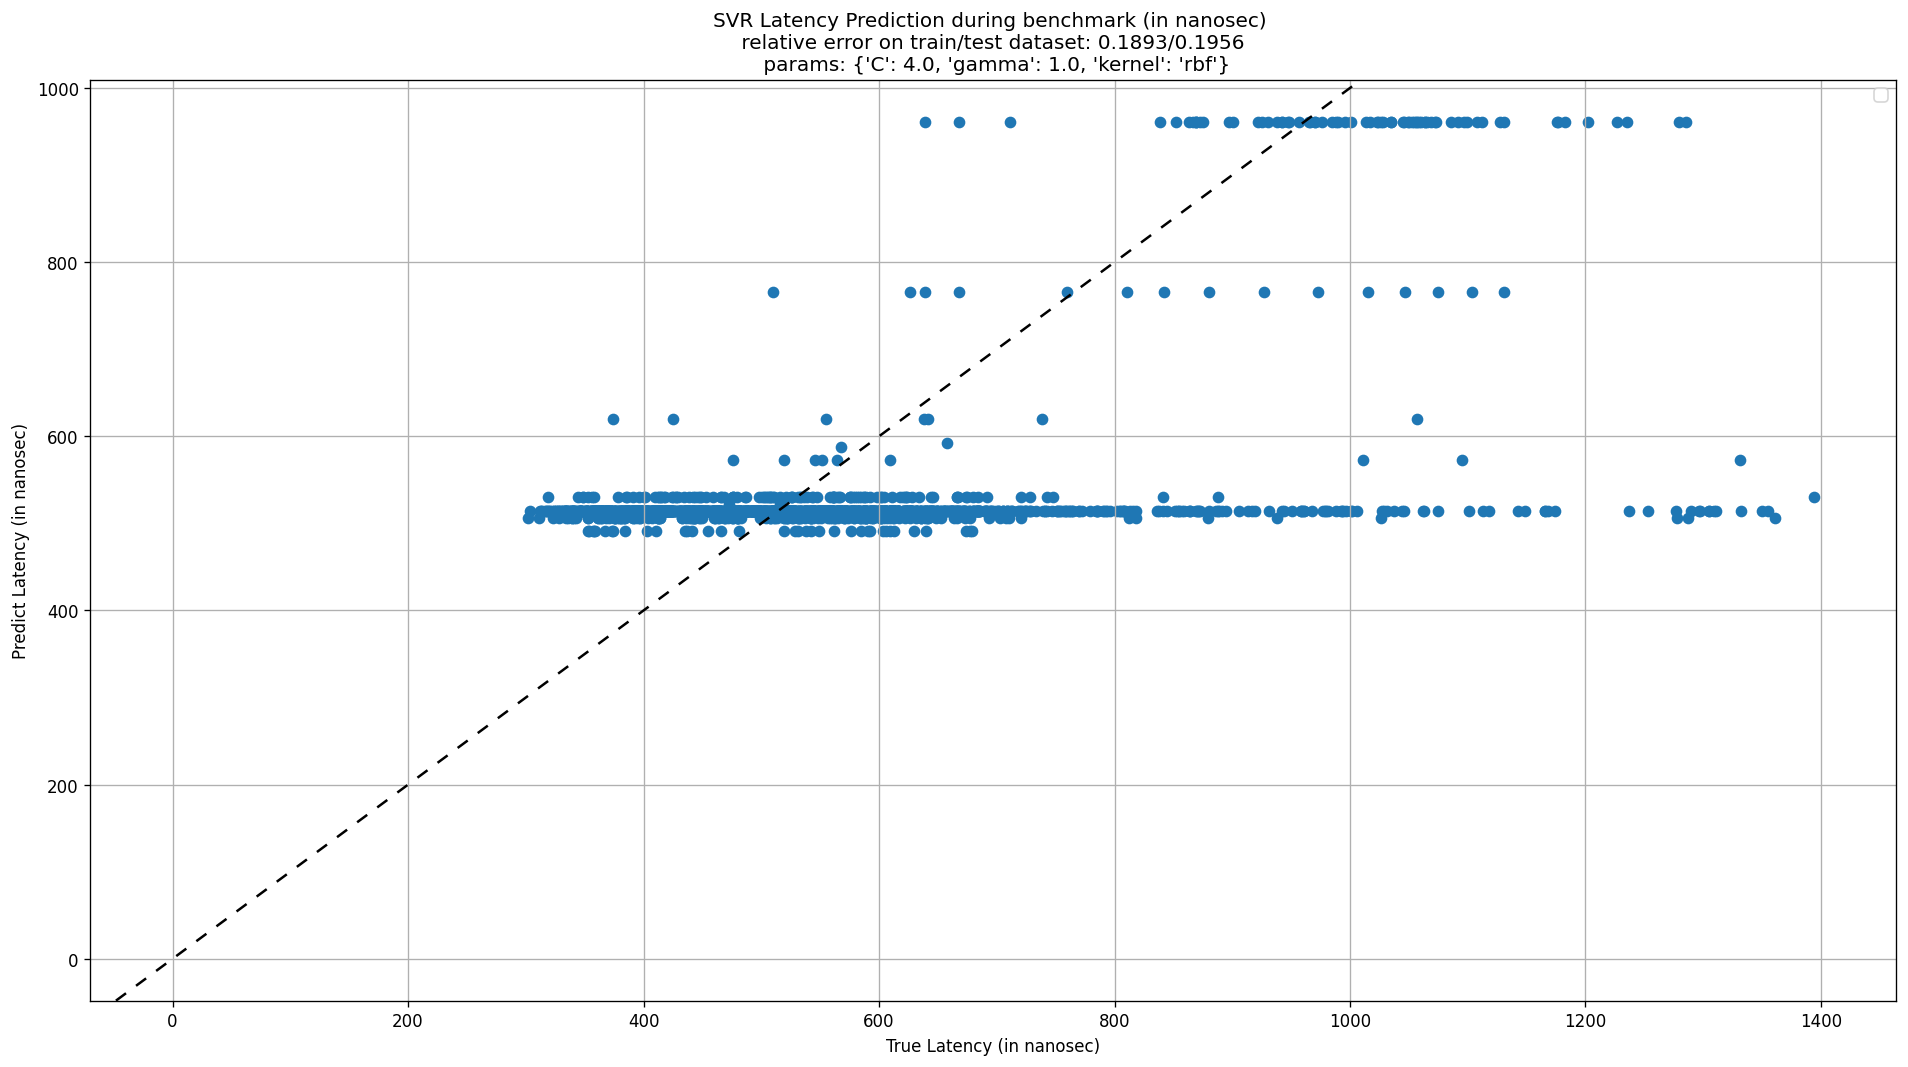

Fitting 5 folds for each of 20 candidates, totalling 100 fits


No handles with labels found to put in legend.


Best training/testing score: 0.2063/0.2118
Best Params: {'alpha': 1, 'epsilon': 1.35}


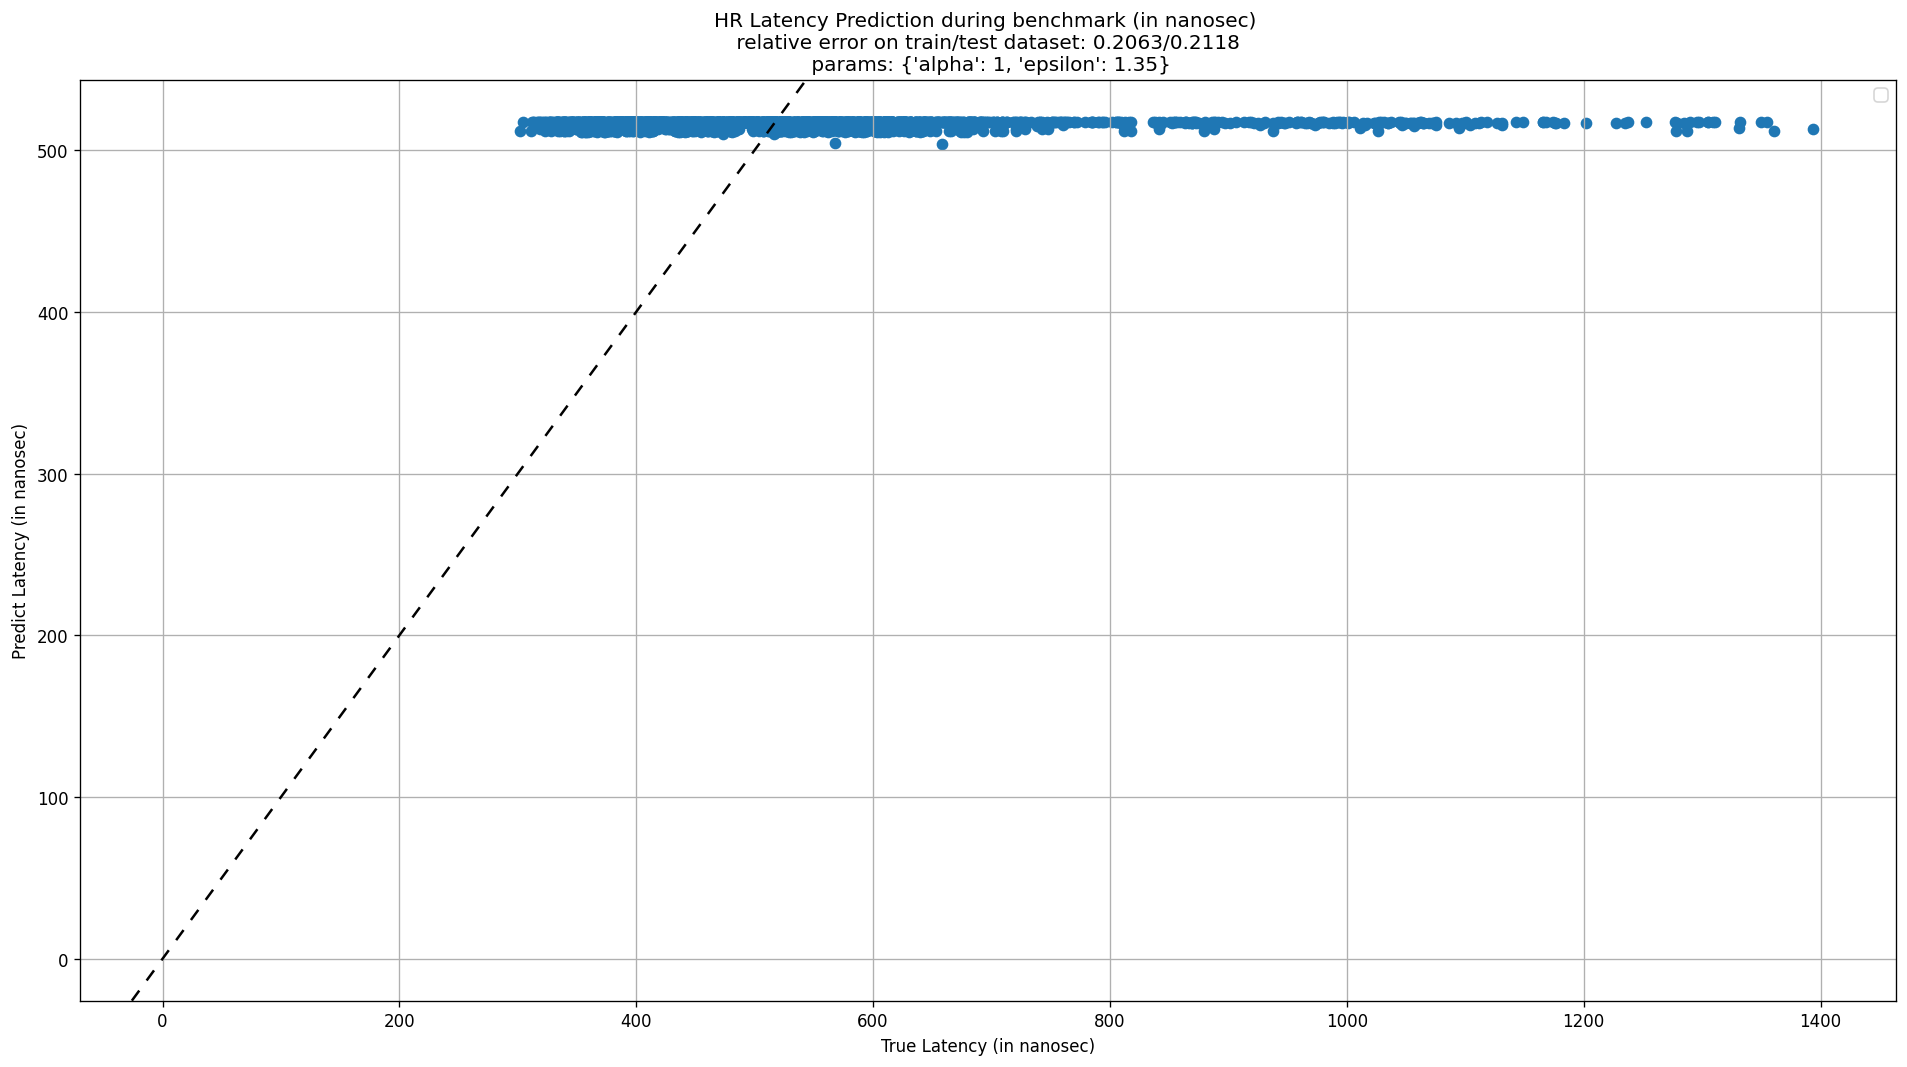

Fitting 5 folds for each of 24 candidates, totalling 120 fits


No handles with labels found to put in legend.


Best training/testing score: 0.1879/0.1951
Best Params: {'criterion': 'mae', 'max_depth': 5, 'n_estimators': 50, 'n_jobs': None, 'random_state': 0}


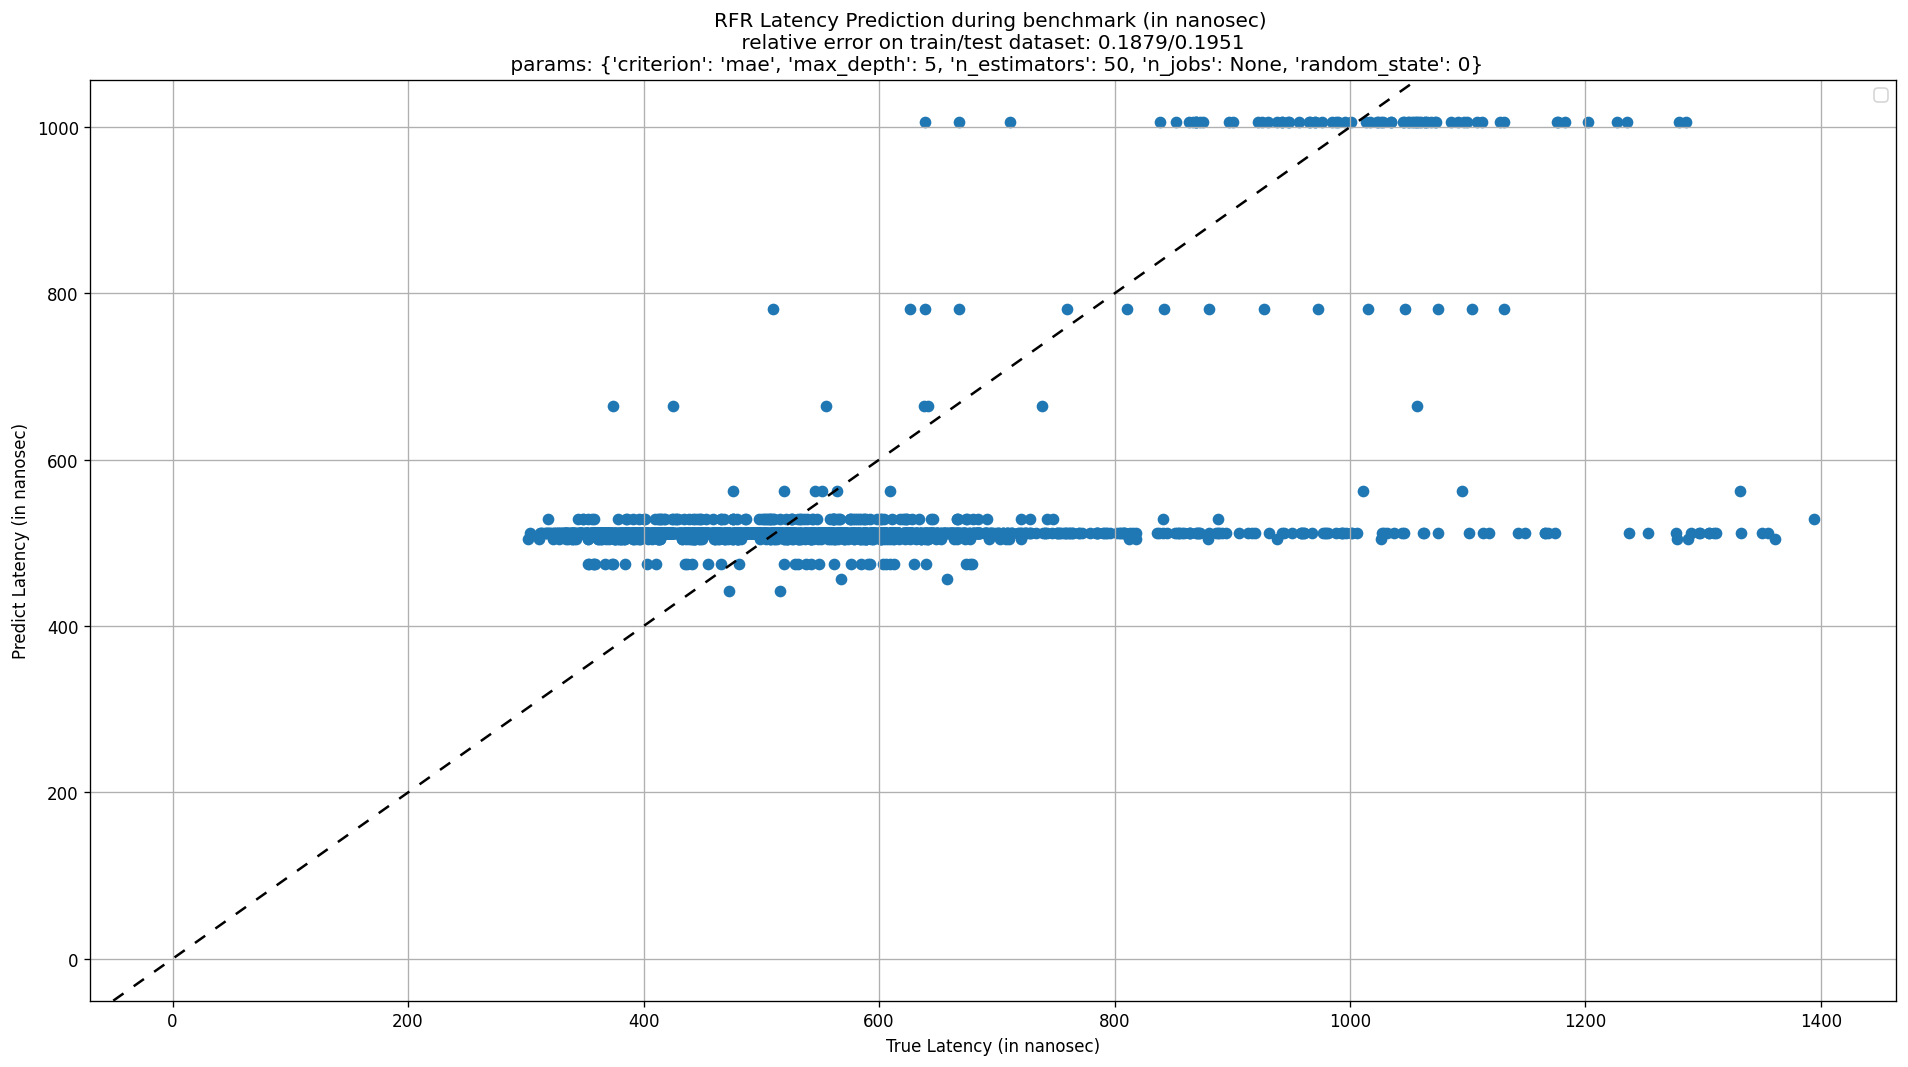

[(GridSearchCV(estimator=KernelRidge(), n_jobs=-1,
               param_grid={'alpha': [1.0], 'gamma': [0.1, 0.5, 1.0, 2.0],
                           'kernel': ['rbf']},
               scoring='neg_mean_absolute_percentage_error', verbose=2),
  0.195,
  0.2027),
 (GridSearchCV(estimator=SVR(), n_jobs=-1,
               param_grid={'C': [0, 0.5, 1.0, 2.0, 4.0],
                           'gamma': [0.1, 0.5, 1.0, 2.0], 'kernel': ['rbf']},
               scoring='neg_mean_absolute_percentage_error', verbose=2),
  0.1893,
  0.1956),
 (GridSearchCV(estimator=HuberRegressor(), n_jobs=-1,
               param_grid={'alpha': [0, 0.0001, 0.01, 0.1, 1],
                           'epsilon': [1.1, 1.35, 2, 5]},
               scoring='neg_mean_absolute_percentage_error', verbose=2),
  0.2063,
  0.2118),
 (GridSearchCV(estimator=RandomForestRegressor(), n_jobs=-1,
               param_grid={'criterion': ['mse', 'mae'],
                           'max_depth': [3, 5, 7, 10],
                      

In [13]:
Parallel(n_jobs=1)(delayed(modelSearch)(m['model'], X_train, X_test, y_train, y_test, name=m['name'], params=m['param'], 
                                        figPath=figPathOU, modelPath=modelPathOU, isSaveFig=isSaveFig, isSaveModel=isSaveModel, n_jobs=-1) for m in modelList)

# Generating Execution Plan

Warm Up Drop Timestamp: 205712299
In microsec, Number of bins: 54, nBins: [ 5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17. 18. 19. 20. 21. 22.
 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35. 36. 37. 38. 39. 40.
 41. 42. 43. 44. 45. 46. 47. 48. 49. 50. 51. 52. 53. 54. 55. 56. 57. 58.]
Mean Latency: 23.71, Std Latency: 12.54 (microsec)


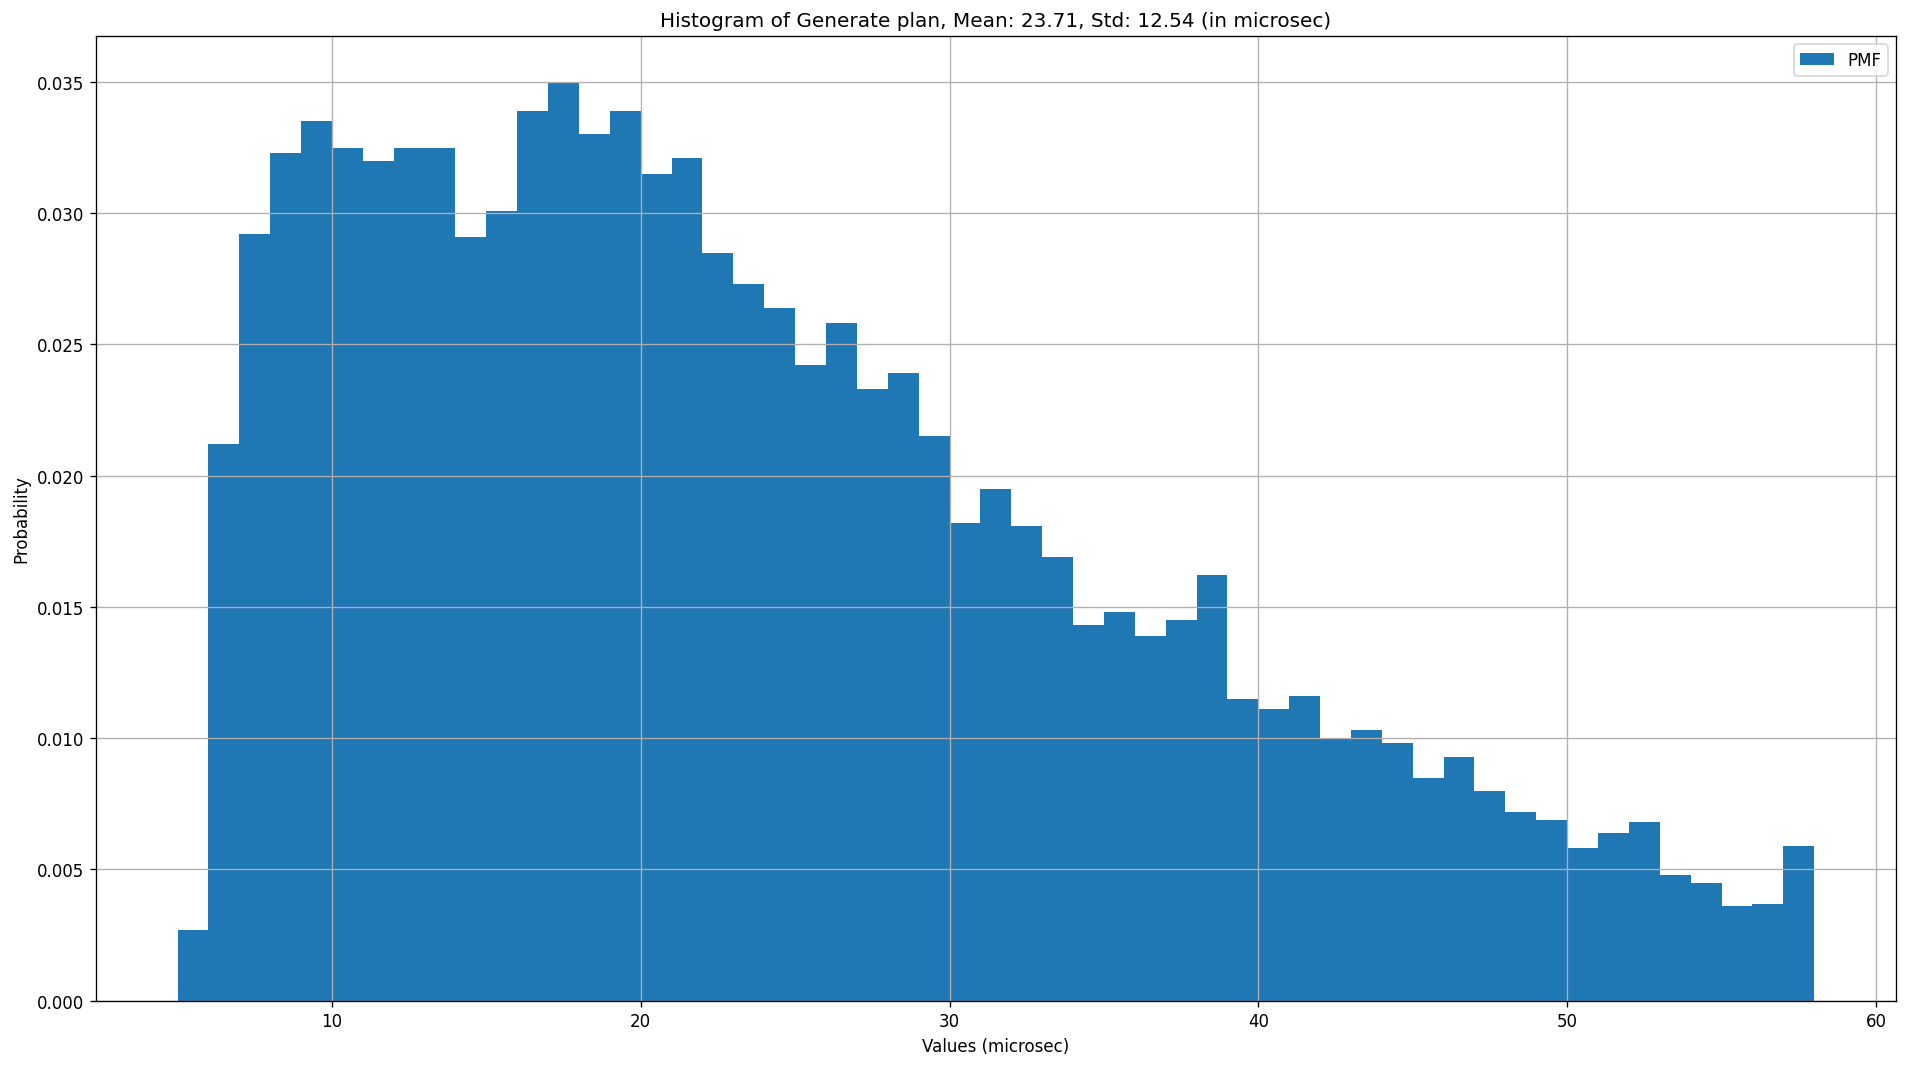

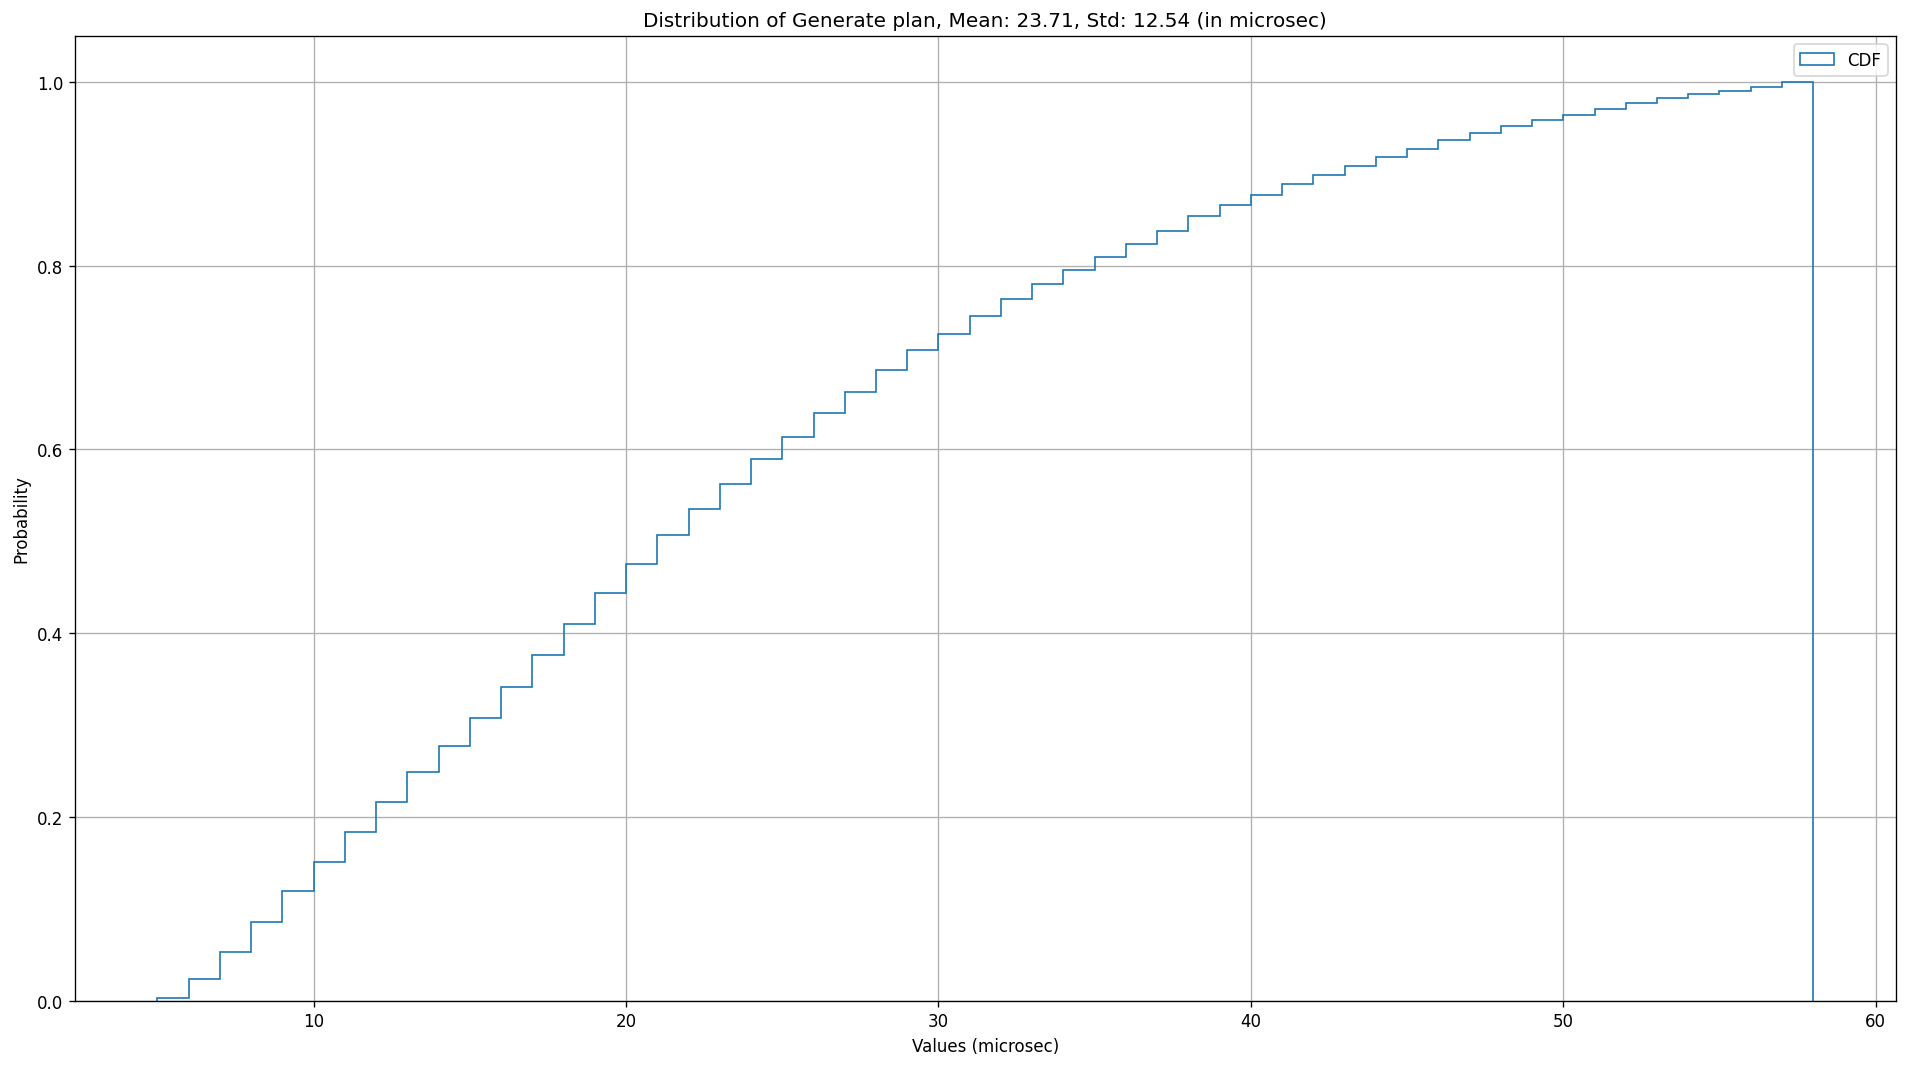

OU1 - Generating Plan Features shape: (10000, 14)


,Num of reads,Num of writes,Num of active txs,Thread pool size,CPU utilization,Num of cache read,Num of cache insert,Num of cache update,Num of arithmetic operations,Num of write record,Num of bytes,Num of read write record,Num of log flush bytes,Num of Threads
0,2,0,1,50,7.0,4,0,0,0,0,0,2,0,61
1,2,0,1,50,4.0,4,0,0,0,0,0,2,0,61
2,2,0,1,50,3.0,4,0,0,0,0,0,2,0,61
3,2,0,1,50,4.0,4,0,0,0,0,0,2,0,61
4,2,0,1,50,3.0,4,0,0,0,0,0,2,0,61
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,2,0,1,50,0.0,4,0,0,0,0,0,2,0,61
9996,2,0,1,50,0.0,4,0,0,0,0,0,2,0,61
9997,2,0,1,50,0.0,4,0,0,0,0,0,2,0,61
9998,2,0,1,50,0.0,4,0,0,0,0,0,2,0,61


OU1 - Generating Plan Targets shape: (10000,)


0       49972
1       49839
2       52165
3       49564
4       51923
        ...  
9995    28470
9996    25061
9997    36186
9998    24552
9999    36267
Name: Generate plan, Length: 10000, dtype: int64

In [14]:
featureNames = [
                'Num of reads', 'Num of writes',
                'Num of active txs', 'Thread pool size', 'CPU utilization',
                'Num of cache read', 'Num of cache insert', 'Num of cache update', 'Num of arithmetic operations',
                'Num of write record', 'Num of bytes',
                'Num of read write record', 'Num of log flush bytes',
                'Num of Threads'
                ]
targetName = 'Generate plan'

# Create path for OU
figPathOU = makePath(figPath, targetName)
modelPathOU = makePath(modelPath, targetName)

genPlanFeatures, genPlanTargets = prepareData(features, records, featureNames=featureNames, targetName=targetName, figPath=figPathOU,
                                              warmupDrop=warmupDrop, outlinerDrop=outlinerDropR, sample=sampleN, histUnit=histUnit, isSaveFig=isSaveFig, isSC=isSC)
print(f'OU1 - Generating Plan Features shape: {genPlanFeatures.shape}')
display(genPlanFeatures)
print(f'OU1 - Generating Plan Targets shape: {genPlanTargets.shape}')
display(genPlanTargets)

X_train, X_test, y_train, y_test = train_test_split(genPlanFeatures, genPlanTargets, test_size=testSize, random_state=randomState)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


No handles with labels found to put in legend.


Best training/testing score: 0.6167/0.6276
Best Params: {'alpha': 1.0, 'gamma': 2.0, 'kernel': 'rbf'}


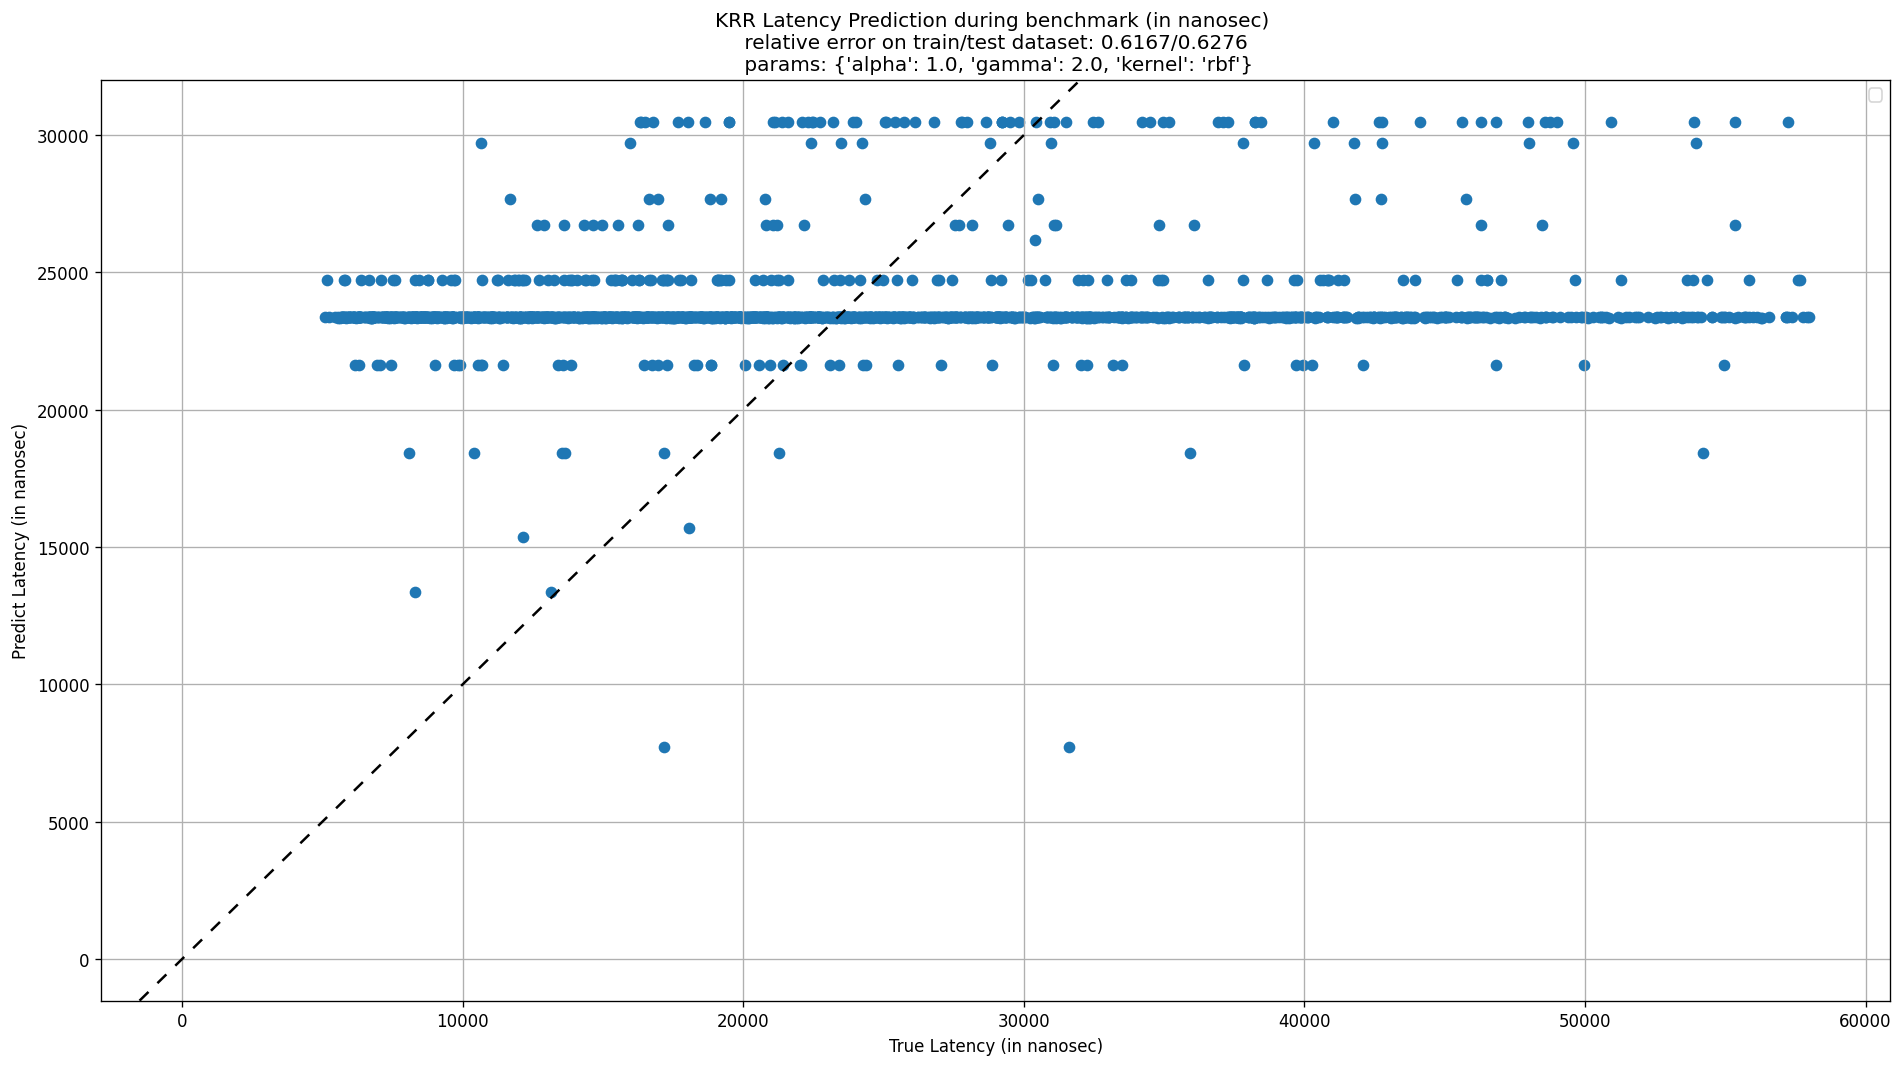

Fitting 5 folds for each of 20 candidates, totalling 100 fits


/home/weidagogo/anaconda3/envs/tempenv/lib/python3.7/site-packages/sklearn/model_selection/_search.py:925: UserWarning: One or more of the test scores are non-finite: [        nan         nan         nan         nan -0.55736852 -0.55725554
 -0.55724327 -0.557221   -0.55722198 -0.5571625  -0.55701028 -0.55693678
 -0.55714448 -0.55692277 -0.55664255 -0.55658529 -0.5569528  -0.5565013
 -0.5564056  -0.55656512]
  category=UserWarning
No handles with labels found to put in legend.


Best training/testing score: 0.5564/0.564
Best Params: {'C': 4.0, 'gamma': 1.0, 'kernel': 'rbf'}


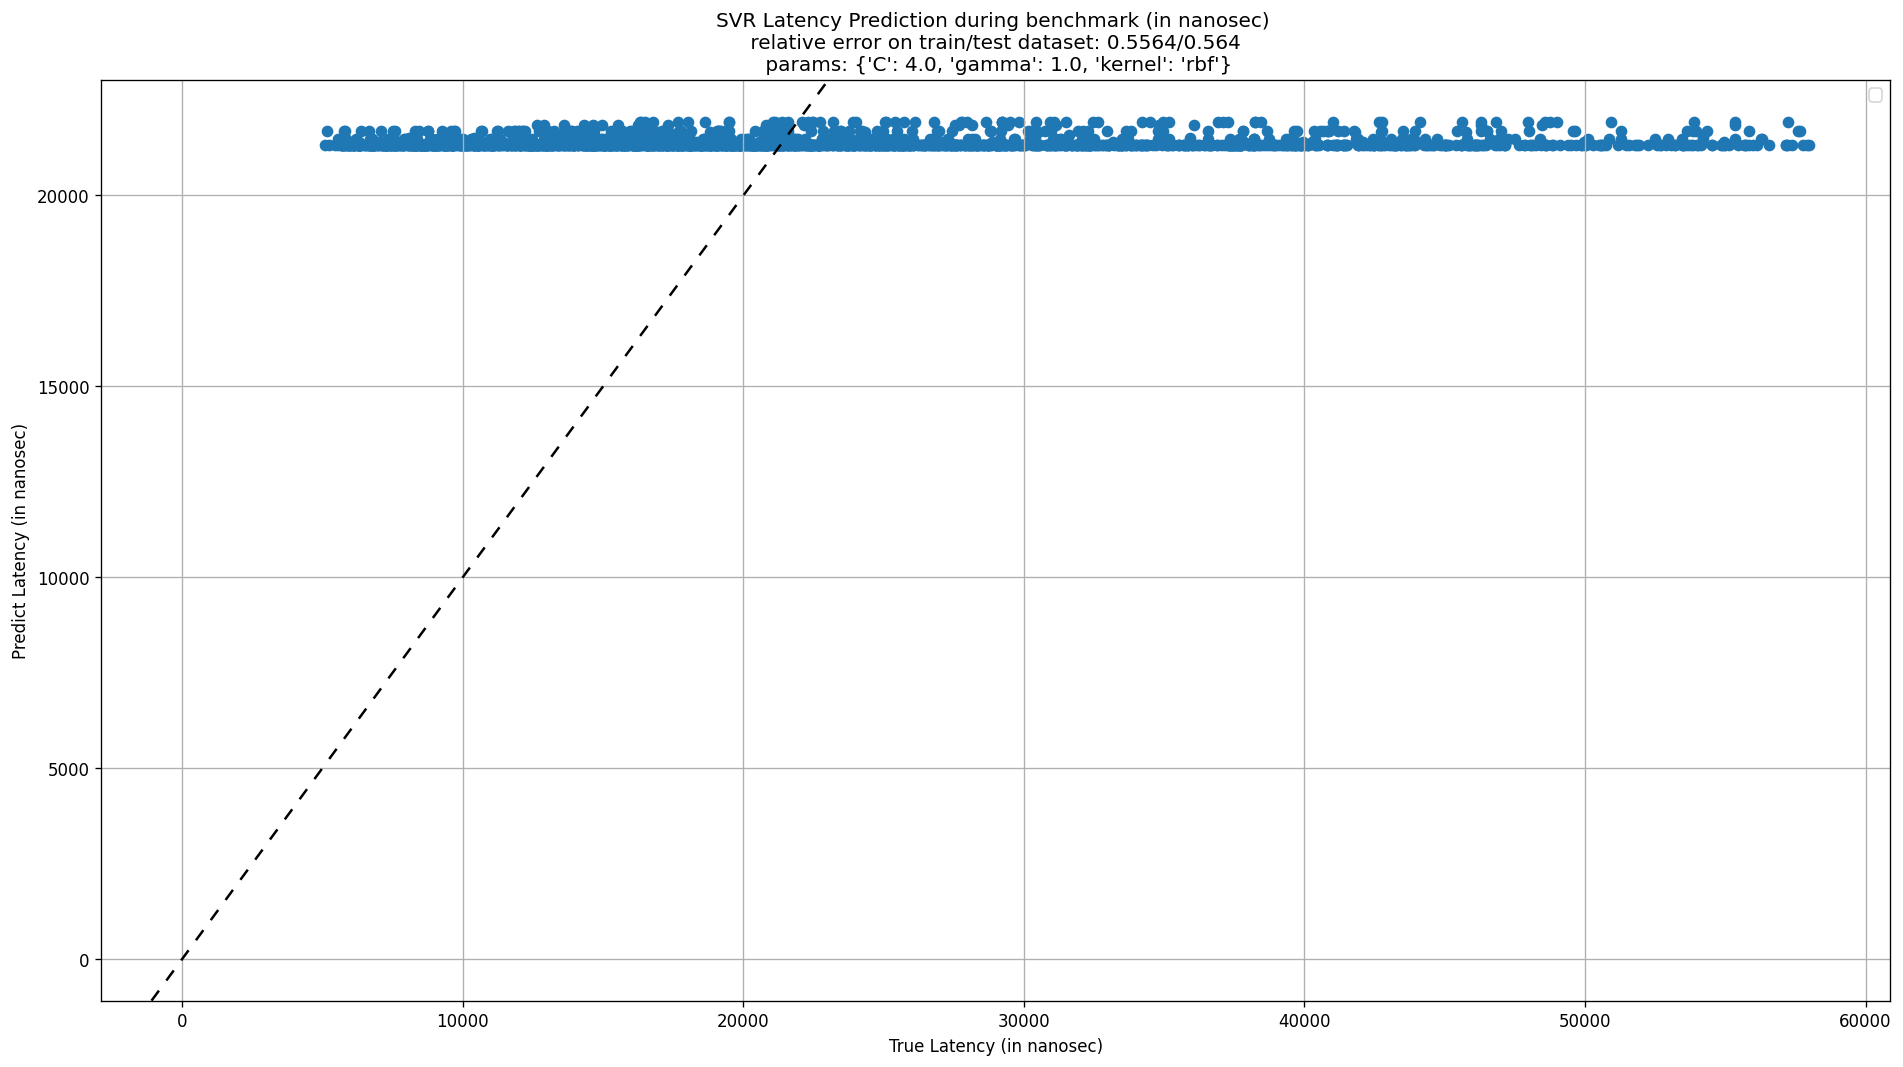

Fitting 5 folds for each of 20 candidates, totalling 100 fits


No handles with labels found to put in legend.


Best training/testing score: 0.5611/0.5693
Best Params: {'alpha': 0.1, 'epsilon': 1.1}


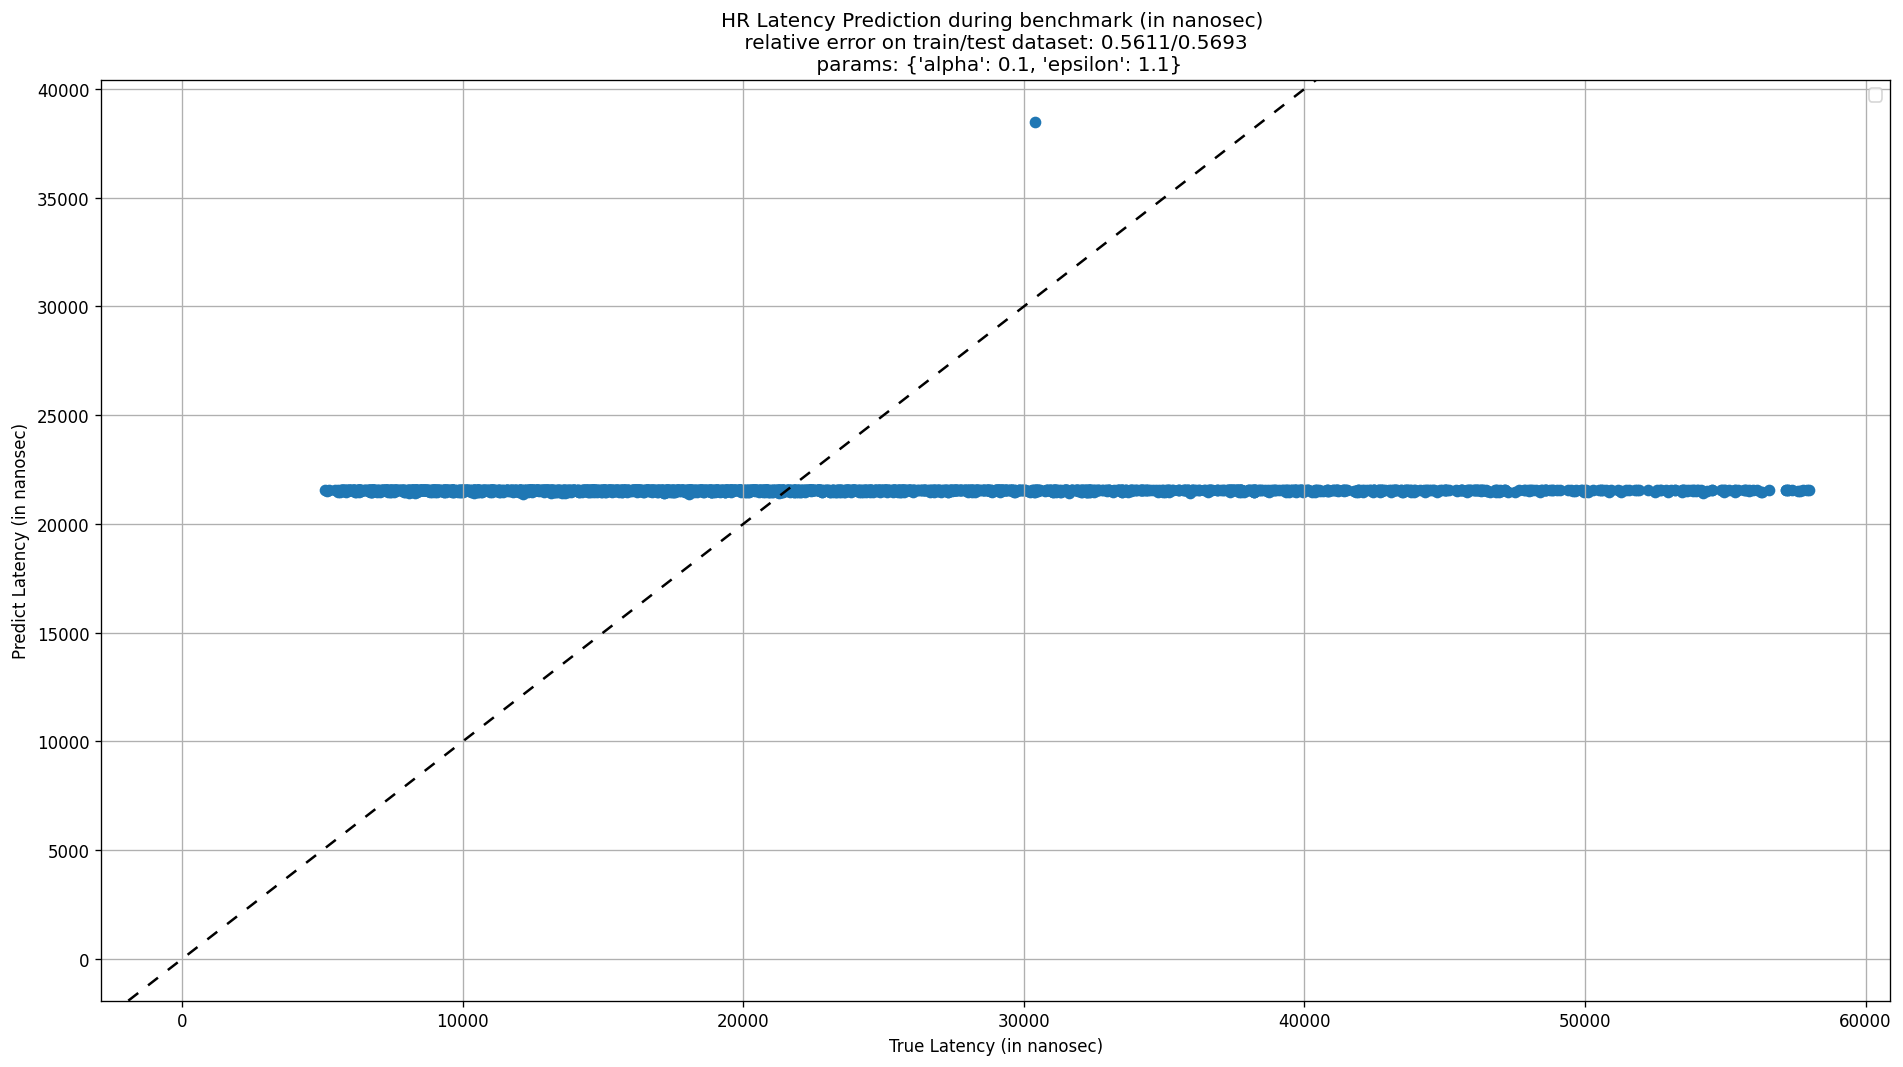

Fitting 5 folds for each of 24 candidates, totalling 120 fits


No handles with labels found to put in legend.


Best training/testing score: 0.5509/0.5571
Best Params: {'criterion': 'mae', 'max_depth': 10, 'n_estimators': 500, 'n_jobs': None, 'random_state': 0}


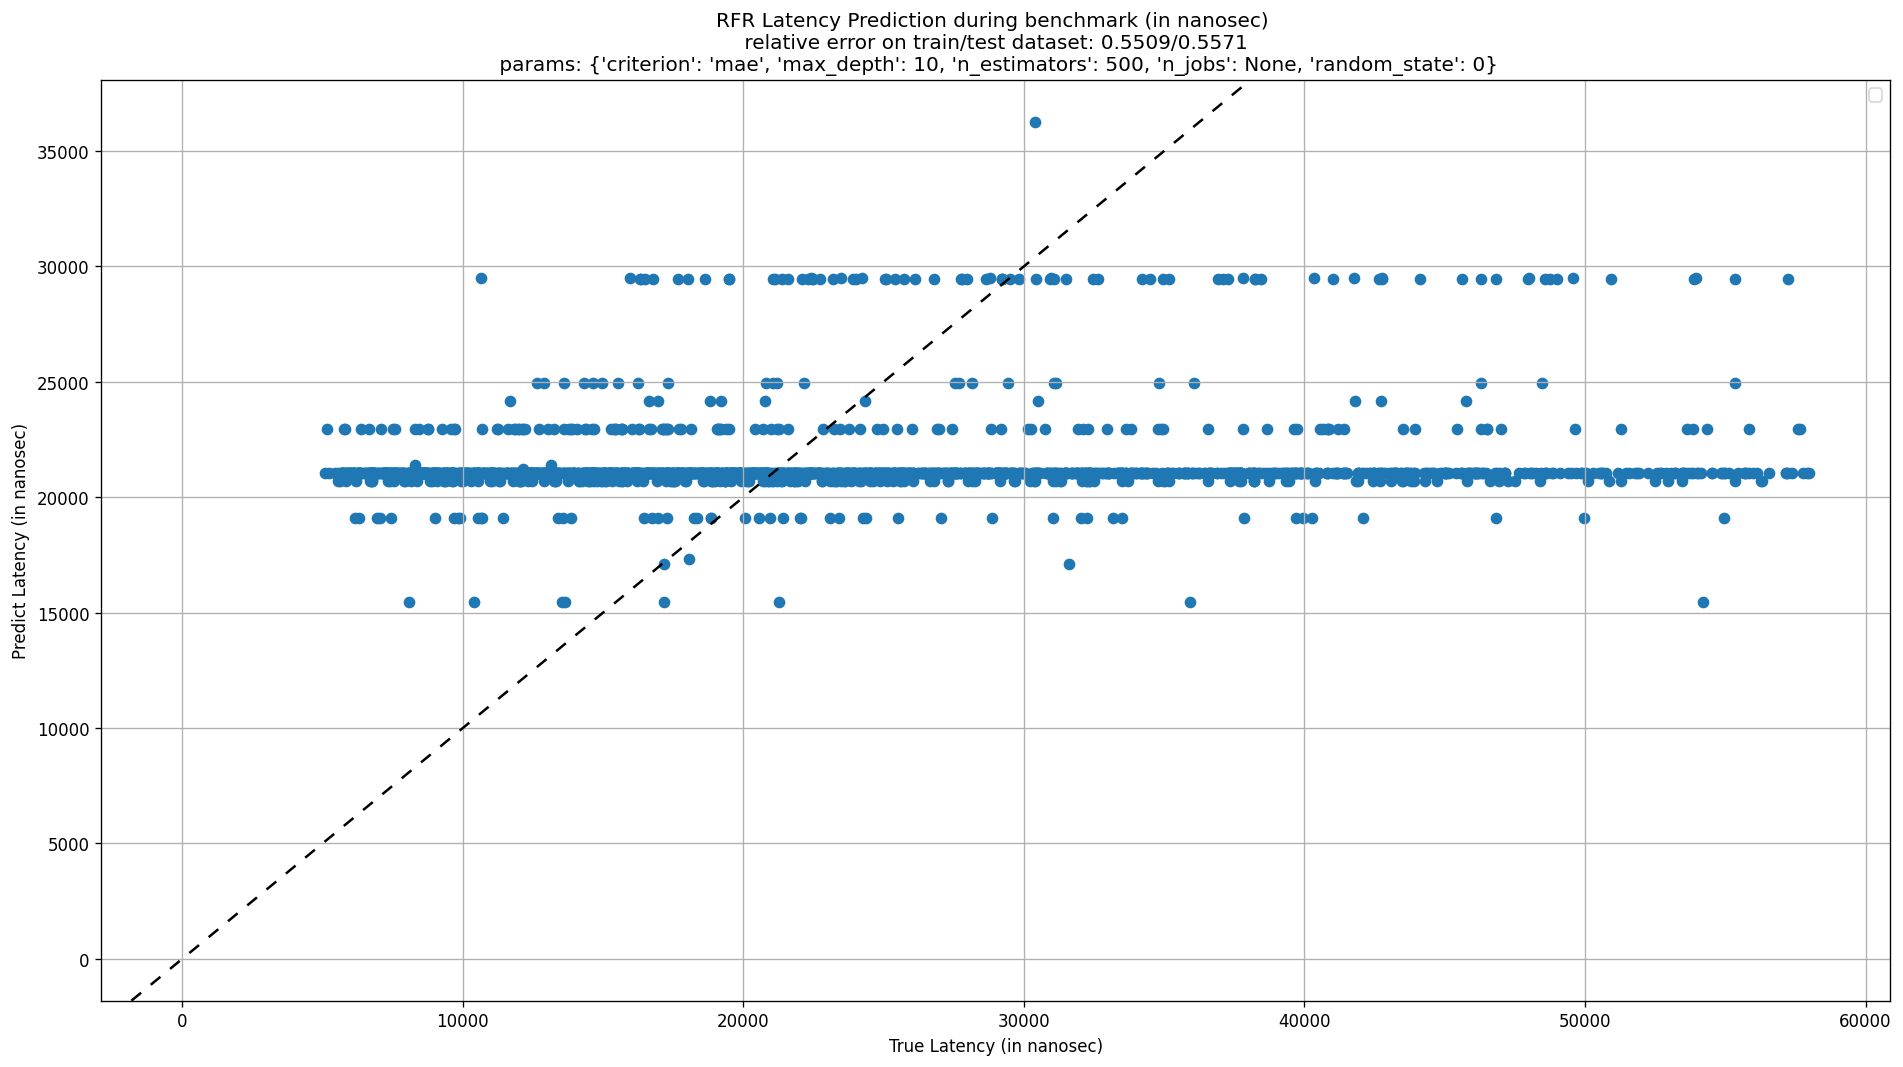

[(GridSearchCV(estimator=KernelRidge(), n_jobs=-1,
               param_grid={'alpha': [1.0], 'gamma': [0.1, 0.5, 1.0, 2.0],
                           'kernel': ['rbf']},
               scoring='neg_mean_absolute_percentage_error', verbose=2),
  0.6167,
  0.6276),
 (GridSearchCV(estimator=SVR(), n_jobs=-1,
               param_grid={'C': [0, 0.5, 1.0, 2.0, 4.0],
                           'gamma': [0.1, 0.5, 1.0, 2.0], 'kernel': ['rbf']},
               scoring='neg_mean_absolute_percentage_error', verbose=2),
  0.5564,
  0.564),
 (GridSearchCV(estimator=HuberRegressor(), n_jobs=-1,
               param_grid={'alpha': [0, 0.0001, 0.01, 0.1, 1],
                           'epsilon': [1.1, 1.35, 2, 5]},
               scoring='neg_mean_absolute_percentage_error', verbose=2),
  0.5611,
  0.5693),
 (GridSearchCV(estimator=RandomForestRegressor(), n_jobs=-1,
               param_grid={'criterion': ['mse', 'mae'],
                           'max_depth': [3, 5, 7, 10],
                      

In [15]:
Parallel(n_jobs=1)(delayed(modelSearch)(m['model'], X_train, X_test, y_train, y_test, name=m['name'], params=m['param'], 
                                        figPath=figPathOU, modelPath=modelPathOU, isSaveFig=isSaveFig, isSaveModel=isSaveModel, n_jobs=-1) for m in modelList)